

**Section 1 - LGBM Regressor**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import json
import ast
import seaborn as sns
import os

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('ggplot')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

Loading JSON Files

In [ ]:
train = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/train.json', \
                     lines=True) # Read the file as a json object per line
test = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/test.json', lines=True)
ss = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')

print(f'Train shape: {train.shape}, test shape: {test.shape}, \
                    sample submission shape: {ss.shape}')

print('========= train columns ==========')
print([c for c in train.columns])

print('========= test columns ==========')
print([c for c in test.columns

Train shape: (2400, 19), test shape: (3634, 7),                     sample submission shape: (457953, 6)
========= train columns ==========
['index', 'id', 'sequence', 'structure', 'predicted_loop_type', 'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
========= test columns ==========
['index', 'id', 'sequence', 'structure', 'predicted_loop_type', 'seq_length', 'seq_scored']


In [ ]:
train.head(3)

index            id                                           sequence  \
0      0  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1      1  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
2      2  id_006f36f57  GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...   

                                           structure  \
0  .....((((((.......)))).)).((.....((..((((((......   
1  .....(((((((((((((((((((((((....)))))))))).)))...   
2  .....((((.((.....((((.(((.....)))..((((......)...   

                                 predicted_loop_type  signal_to_noise  \
0  EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...            6.894   
1  EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...            0.193   
2  EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...            8.800   

   SN_filter  seq_length  seq_scored  \
0          1         107          68   
1          0         107          68   
2          1         107          68   

                                    reactivity_error  \
0  [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...   
1  [2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...   
2  [0.0931, 0.13290000000000002, 0.11280000000000...   

                                   deg_error_Mg_pH10  \
0  [0.26130000000000003, 0.38420000000000004, 0.1...   
1  [73705.3985, 73705.3985, 73705.3985, 73705.398...   
2  [0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...   

                                      deg_error_pH10  \
0  [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...   
1  [10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...   
2  [0.17020000000000002, 0.178, 0.111, 0.091, 0.0...   

                                    deg_error_Mg_50C  \
0  [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...   
1  [16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...   
2  [0.1033, 0.1464, 0.1126, 0.09620000000000001, ...   

                                       deg_error_50C  \
0  [0.2167, 0.34750000000000003, 0.188, 0.2124, 0...   
1  [15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...   
2  [0.14980000000000002, 0.1761, 0.1517, 0.116700...   

                                          reactivity  \
0  [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...   
1  [0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....   
2  [0.44820000000000004, 1.4822, 1.1819, 0.743400...   

                                         deg_Mg_pH10  \
0  [0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.2504, 1.4021, 0.9804, 0.49670000000000003, ...   

                                            deg_pH10  \
0  [2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...   
1  [4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...   

                                          deg_Mg_50C  \
0  [0.35810000000000003, 2.9683, 0.2589, 1.4552, ...   
1  [4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...   

                                             deg_50C  
0  [0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...  
1  [7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...  
2  [0.9501000000000001, 1.7974999999999999, 1.499...

In [ ]:
test.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'seq_length', 'seq_scored'],
      dtype='object')

In [ ]:
train_data = []
for molecule_id in train['id'].unique():
    sample_data = train.loc[train['id'] == molecule_id]
    for i in range(68):
        sample_tuple = (sample_data['id'].values[0], sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i],
                        sample_data['reactivity'].values[0][i], sample_data['reactivity_error'].values[0][i],
                        sample_data['deg_Mg_pH10'].values[0][i], sample_data['deg_error_Mg_pH10'].values[0][i],
                        sample_data['deg_pH10'].values[0][i], sample_data['deg_error_pH10'].values[0][i],
                        sample_data['deg_Mg_50C'].values[0][i], sample_data['deg_error_Mg_50C'].values[0][i],
                        sample_data['deg_50C'].values[0][i], sample_data['deg_error_50C'].values[0][i])
        train_data.append(sample_tuple)

In [ ]:
train_data = pd.DataFrame(train_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type', 'reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10',
                                  'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C'])
train_data.head()

id sequence structure predicted_loop_type  reactivity  \
0  id_001f94081        G         .                   E      0.3297   
1  id_001f94081        G         .                   E      1.5693   
2  id_001f94081        A         .                   E      1.1227   
3  id_001f94081        A         .                   E      0.8686   
4  id_001f94081        A         .                   E      0.7217   

   reactivity_error  deg_Mg_pH10  deg_error_Mg_pH10  deg_pH10  deg_error_pH10  \
0            0.1359       0.7556             0.2613    2.3375          0.2631   
1            0.2070       2.9830             0.3842    3.5060          0.2860   
2            0.1633       0.2526             0.1372    0.3008          0.0964   
3            0.1452       1.3789             0.2531    1.0108          0.1574   
4            0.1314       0.6376             0.1798    0.2635          0.1000   

   deg_Mg_50C  deg_error_Mg_50C  deg_50C  deg_error_50C  
0      0.3581            0.1501   0.6382         0.2167  
1      2.9683            0.2750   3.4773         0.3475  
2      0.2589            0.0947   0.9988         0.1880  
3      1.4552            0.1866   1.3228         0.2124  
4      0.7244            0.1369   0.7877         0.1703

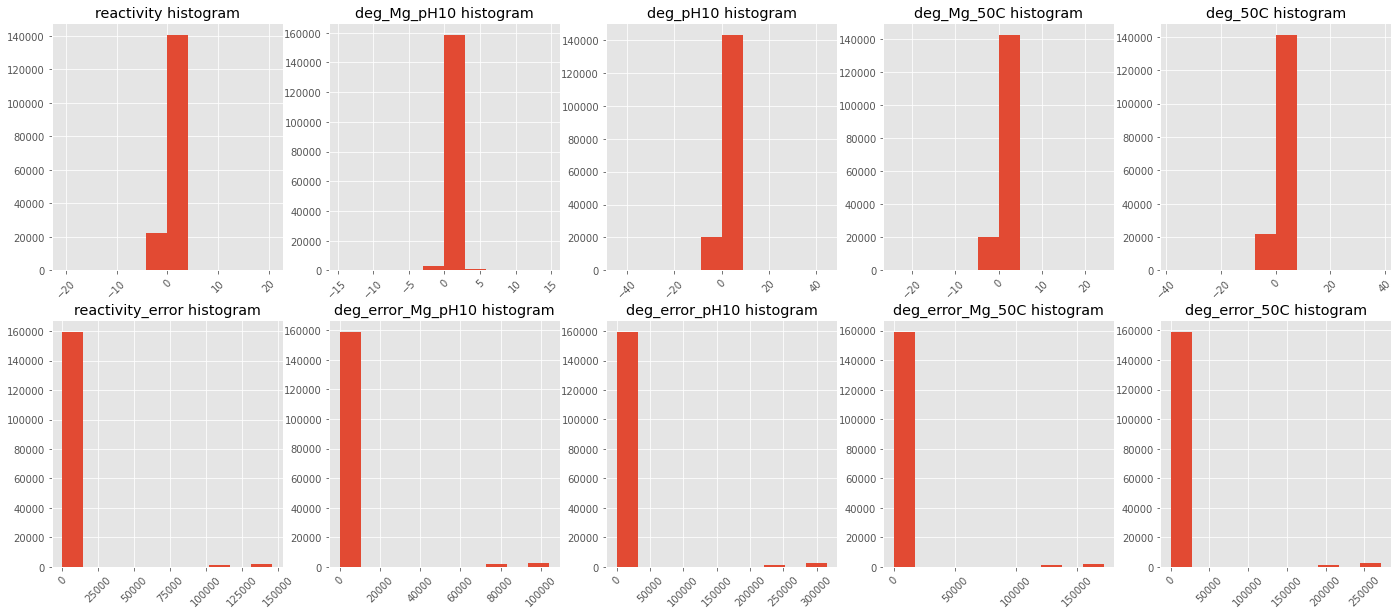

In [ ]:
fig, ax = plt.subplots(figsize = (24, 10))
for i, col in enumerate(['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']):
    plt.subplot(2, 5, i + 1);
    plt.hist(train_data[col])
    plt.title(f'{col} histogram');
    plt.xticks(rotation=45)

In [ ]:
train_data.sort_values('reactivity_error')

id sequence structure predicted_loop_type  reactivity  \
54443   id_5429cb841        A         )                   S      0.0000   
26991   id_2a3308237        C         )                   S      0.0016   
54421   id_5429cb841        U         (                   S     -0.0009   
26993   id_2a3308237        A         )                   S      0.0024   
85089   id_8622860d7        U         (                   S      0.0000   
...              ...      ...       ...                 ...         ...   
101750  id_a1719ebbc        G         (                   S      0.0000   
101751  id_a1719ebbc        C         (                   S      0.0000   
101752  id_a1719ebbc        G         (                   S      0.0000   
101754  id_a1719ebbc        G         (                   S      0.0000   
24034   id_251bb7979        G         .                   I      0.0000   

        reactivity_error  deg_Mg_pH10  deg_error_Mg_pH10  deg_pH10  \
54443             0.0019       0.0331             0.0173    0.0608   
26991             0.0022       0.0426             0.0066    0.0336   
54421             0.0029       0.0250             0.0234    0.0056   
26993             0.0031       0.0950             0.0094    0.0641   
85089             0.0031       0.0102             0.0204    0.0051   
...                  ...          ...                ...       ...   
101750       146151.2250       0.0000        104235.1742    0.0000   
101751       146151.2250       0.0000        104235.1742    0.0000   
101752       146151.2250       0.0000        104235.1742    0.0000   
101754       146151.2250       0.0000        104235.1742    0.0000   
24034        146151.2250       0.0000        104235.1742    0.0000   

        deg_error_pH10  deg_Mg_50C  deg_error_Mg_50C  deg_50C  deg_error_50C  
54443           0.0178      0.0072            0.0066   0.0233         0.0135  
26991           0.0097      0.0481            0.0089   0.0377         0.0115  
54421           0.0101      0.0019            0.0065   0.0071         0.0113  
26993           0.0131      0.0761            0.0110   0.0547         0.0138  
85089           0.0105      0.0115            0.0106   0.0057         0.0117  
...                ...         ...               ...      ...            ...  
101750     314833.5695      0.0000       171525.3217   0.0000    271158.6040  
101751     314833.5695      0.0000       171525.3217   0.0000    271158.6040  
101752     314833.5695      0.0000       171525.3217   0.0000    271158.6040  
101754     314833.5695      0.0000       171525.3217   0.0000    271158.6040  
24034      314833.5695      0.0000       171525.3217   0.0000    271158.6040  

[163200 rows x 14 columns]

In [ ]:
train.loc[train['id'] == 'id_a1719ebbc']

index            id                                           sequence  \
1496   1496  id_a1719ebbc  GGAAACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCCGCGCGCG...   

                                              structure  \
1496  .....((((((((((((((((((((((((((((((...))))))))...   

                                    predicted_loop_type  signal_to_noise  \
1496  EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSHHHSSSSSSSS...              0.0   

      SN_filter  seq_length  seq_scored  \
1496          0         107          68   

                                       reactivity_error  \
1496  [146151.225, 146151.225, 146151.225, 146151.22...   

                                      deg_error_Mg_pH10  \
1496  [104235.1742, 104235.1742, 104235.1742, 104235...   

                                         deg_error_pH10  \
1496  [314833.5695, 314833.5695, 314833.5695, 314833...   

                                       deg_error_Mg_50C  \
1496  [171525.3217, 171525.3217, 171525.3217, 171525...   

                                          deg_error_50C  \
1496  [271158.604, 271158.604, 271158.604, 271158.60...   

                                             reactivity  \
1496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            deg_Mg_pH10  \
1496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               deg_pH10  \
1496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             deg_Mg_50C  \
1496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                deg_50C  
1496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [ ]:
test_data = []
for mol_id in test['id'].unique():
    sample_data = test.loc[test['id'] == mol_id]
    for i in range(sample_data['seq_scored'].values[0]):
        sample_tuple = (sample_data['id'].values[0] + f'_{i}', #what does f'_{i}' mean
                        sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], 
                        sample_data['predicted_loop_type'].values[0][i])
        test_data.append(sample_tuple)

In [ ]:
test_data = pd.DataFrame(test_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type'])
test_data.head()

id sequence structure predicted_loop_type
0  id_00073f8be_0        G         .                   E
1  id_00073f8be_1        G         .                   E
2  id_00073f8be_2        A         .                   E
3  id_00073f8be_3        A         .                   E
4  id_00073f8be_4        A         .                   E

In [ ]:
bpps_files = os.listdir('/content/drive/My Drive/bpps1/')
example_bpps = np.load(f'/content/drive/My Drive/bpps1/{bpps_files[0]}')
print('bpps file shape:', example_bpps.shape)

bpps file shape: (107, 107)


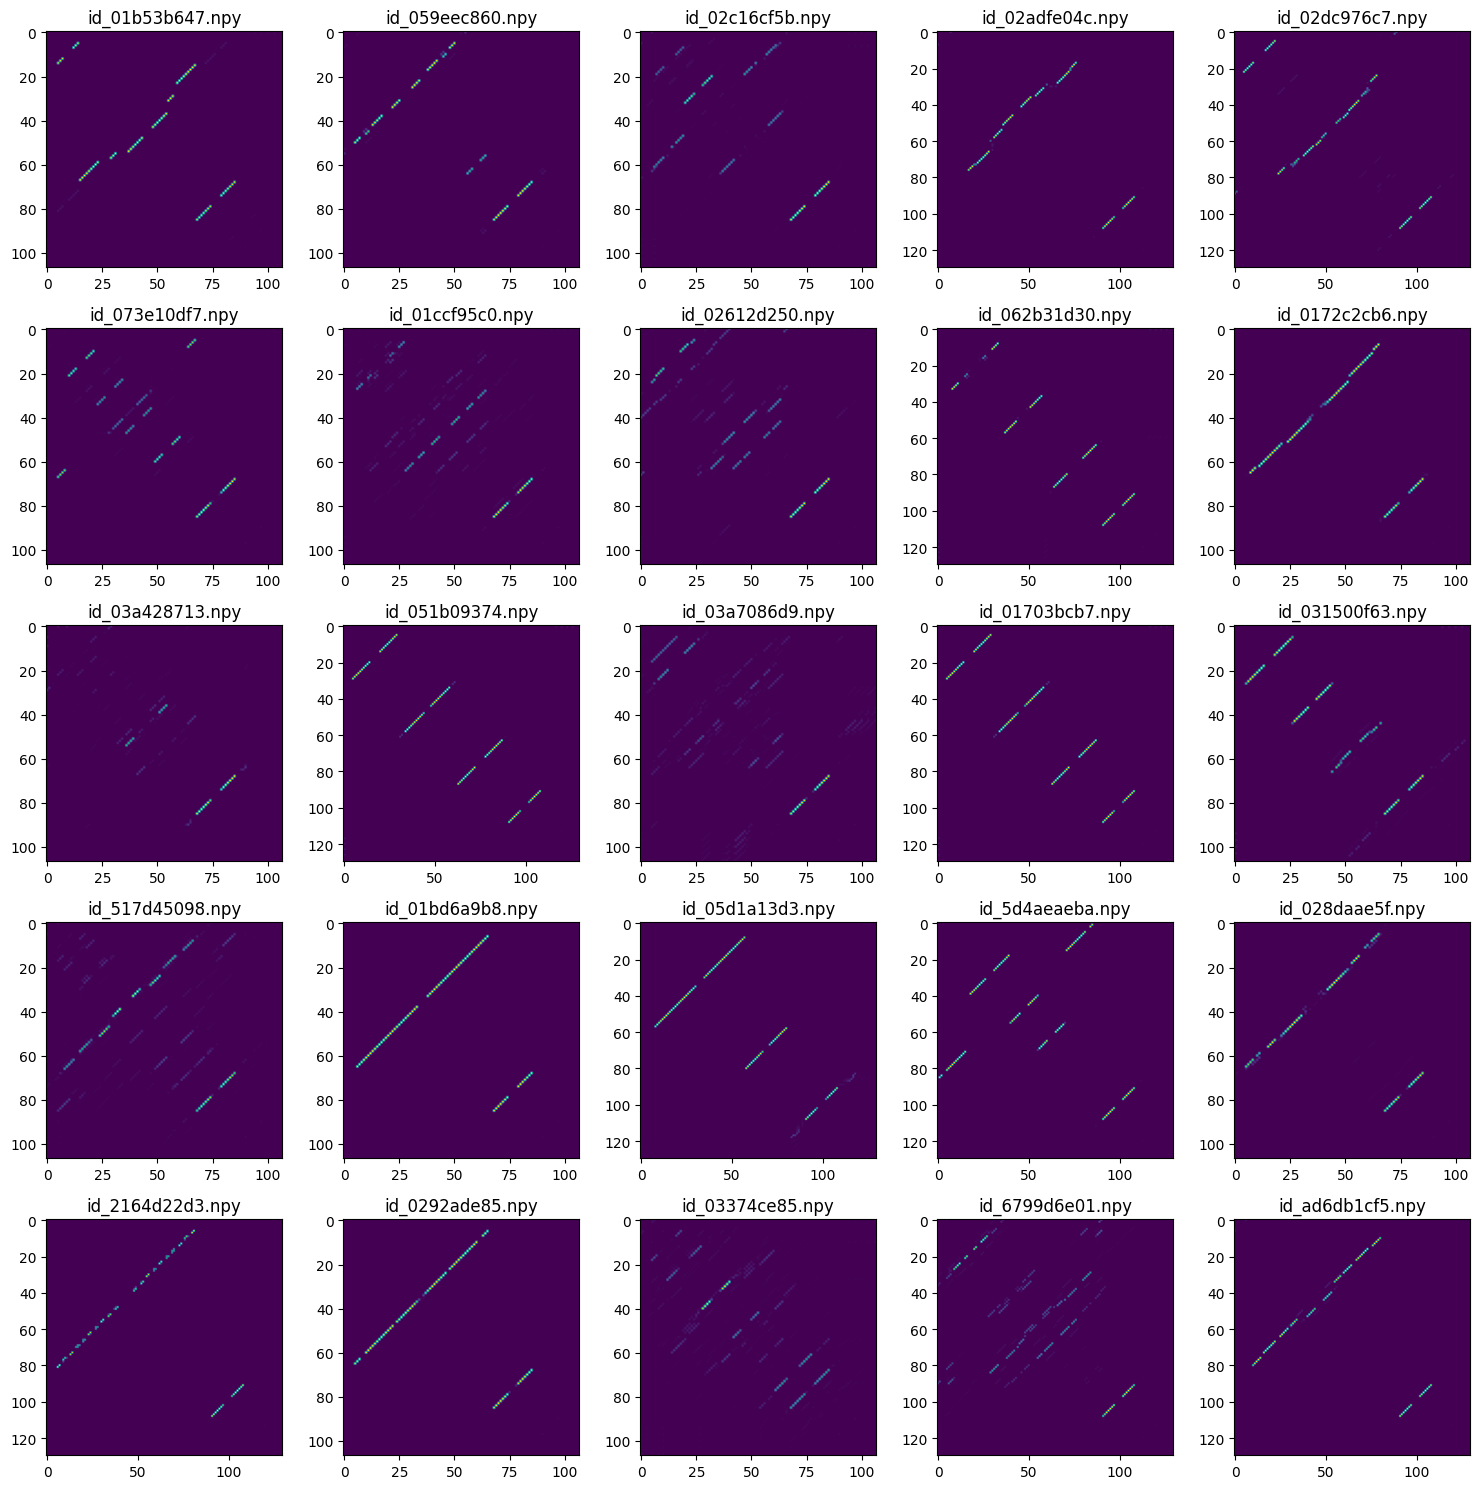

In [ ]:
plt.style.use('default')
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()
for i, f in enumerate(bpps_files):
    if i == 25:
        break
    example_bpps = np.load(f'/content/drive/MyDrive/bpps1/{f}')
    axs[i].imshow(example_bpps)
    axs[i].set_title(f)
plt.tight_layout()
plt.show()

In [ ]:
ss.head()

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  deg_50C
0  id_00073f8be_0         0.0          0.0       0.0         0.0      0.0
1  id_00073f8be_1         0.0          0.0       0.0         0.0      0.0
2  id_00073f8be_2         0.0          0.0       0.0         0.0      0.0
3  id_00073f8be_3         0.0          0.0       0.0         0.0      0.0
4  id_00073f8be_4         0.0          0.0       0.0         0.0      0.0

In [ ]:
train['reactivity'].head()

0    [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...
1    [0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....
2    [0.44820000000000004, 1.4822, 1.1819, 0.743400...
3    [0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....
4    [0.8267, 2.6577, 2.8481, 0.40090000000000003, ...
Name: reactivity, dtype: object

In [ ]:
print('===== Example Train Reacivity ======')
print([round(r, 2) for r in train['reactivity'][0]])

===== Example Train Reacivity ======
[0.33, 1.57, 1.12, 0.87, 0.72, 0.44, 0.26, 0.34, 0.22, 0.36, 0.95, 1.41, 1.69, 1.25, 1.19, 0.69, 0.47, 0.18, 0.06, 0.22, 0.08, 0.82, 0.76, 0.11, 0.26, 0.09, 0.16, 0.77, 0.16, 0.5, 1.04, 0.48, 0.56, 0.91, 1.01, 1.05, 1.04, 0.45, 0.21, 0.05, 0.08, 0.06, 0.15, 0.09, 0.51, 1.07, 0.32, 0.07, 0.02, 0.01, 0.2, 0.5, 1.06, 0.64, 0.68, 0.36, 0.17, 0.14, 0.16, 0.54, 0.68, 0.43, 0.05, 0.07, 0.14, 0.29, 0.24, 0.57]


In [ ]:
print('===== Example Train deg_Mg_pH10 value ======')
print([round(r, 2) for r in train['deg_Mg_pH10'][0]])

===== Example Train deg_Mg_pH10 value ======
[0.76, 2.98, 0.25, 1.38, 0.64, 0.33, 0.68, 0.75, 0.21, 0.89, 0.99, 0.87, 1.74, 1.38, 0.77, 0.72, 0.72, 0.41, 0.26, 0.36, 0.07, 0.48, 0.28, 0.49, 0.44, 0.33, 0.09, 0.42, 0.23, 0.41, 0.52, 0.27, 0.32, 0.91, 0.88, 0.9, 0.73, 0.48, 0.12, 0.2, 0.18, 0.13, 0.27, 0.88, 0.88, 0.87, 0.51, 0.35, 0.04, 0.12, 0.46, 0.32, 2.12, 0.37, 0.35, 0.27, 0.32, 0.18, 0.33, 0.47, 0.61, 0.31, 0.14, 0.13, 0.16, 0.33, 0.65, 0.69]


In [ ]:
print('===== Example Train deg_Mg_50C value ======')
print([round(r, 2) for r in train['deg_Mg_50C'][0]])

===== Example Train deg_Mg_50C value ======
[0.36, 2.97, 0.26, 1.46, 0.72, 0.5, 0.38, 0.91, 0.17, 1.06, 1.13, 0.75, 1.9, 1.1, 0.73, 0.76, 0.7, 0.43, 0.24, 0.4, 0.04, 0.34, 0.29, 0.4, 0.31, 0.31, 0.24, 0.2, 0.37, 0.45, 0.63, 0.21, 0.62, 1.06, 0.87, 0.92, 0.85, 0.63, 0.18, 0.4, 0.22, 0.15, 0.15, 0.66, 0.57, 0.46, 0.27, 0.28, 0.03, 0.04, 0.23, 0.29, 1.75, 0.32, 0.3, 0.2, 0.23, 0.2, 0.41, 0.55, 0.38, 0.34, 0.19, 0.26, 0.27, 0.48, 0.7, 0.43]


In [ ]:
#============== New Addition ======================
print('===== Example Train deg_pH10 value ======')
print([round(r, 2) for r in train['deg_pH10'][0]])

===== Example Train deg_pH10 value ======
[2.34, 3.51, 0.3, 1.01, 0.26, 0.34, 0.56, 0.68, 0.05, 0.53, 0.55, 0.33, 1.08, 0.77, 0.39, 0.5, 0.65, 0.52, 0.22, 0.23, 0.06, 0.43, 0.33, 0.27, 0.47, 0.48, 0.13, 0.69, 0.23, 0.12, 0.83, 0.13, 0.59, 0.72, 0.79, 0.72, 0.81, 0.48, 0.18, 0.13, 0.22, 0.12, 0.17, 0.43, 0.42, 0.46, 0.36, 0.22, 0.05, 0.07, 0.24, 0.1, 0.93, 0.25, 0.29, 0.15, 0.25, 0.25, 0.41, 0.74, 0.94, 0.31, 0.35, 0.41, 0.22, 0.51, 0.77, 1.17]


In [ ]:
#============== New Addition ======================
print('===== Example Train deg_50C value ======')
print([round(r, 2) for r in train['deg_50C'][0]])

===== Example Train deg_50C value ======
[0.64, 3.48, 1.0, 1.32, 0.79, 0.59, 0.52, 1.01, 0.06, 0.73, 1.22, 1.03, 0.83, 1.04, 0.85, 0.55, 0.73, 0.55, 0.24, 0.36, 0.15, 0.62, 0.41, 0.46, 0.6, 0.67, 0.3, 0.84, 0.39, 0.42, 0.72, 0.3, 0.95, 1.25, 1.03, 0.79, 1.04, 0.66, 0.19, 0.36, 0.38, 0.15, 0.26, 0.49, 0.75, 0.63, 0.35, 0.3, 0.09, 0.14, 0.43, 0.36, 0.79, 0.23, 0.35, 0.15, 0.16, 0.16, 0.39, 0.37, 0.44, 0.22, 0.2, 0.24, 0.42, 0.33, 0.53, 0.85]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


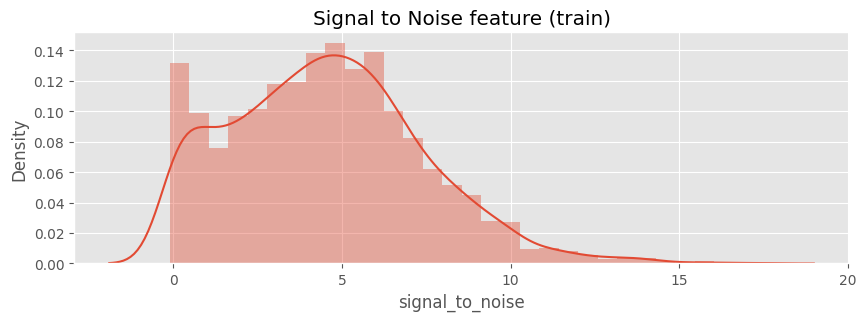

In [ ]:
#what is the significance of this plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.distplot(train['signal_to_noise'])
ax.set_title('Signal to Noise feature (train)')
plt.show()

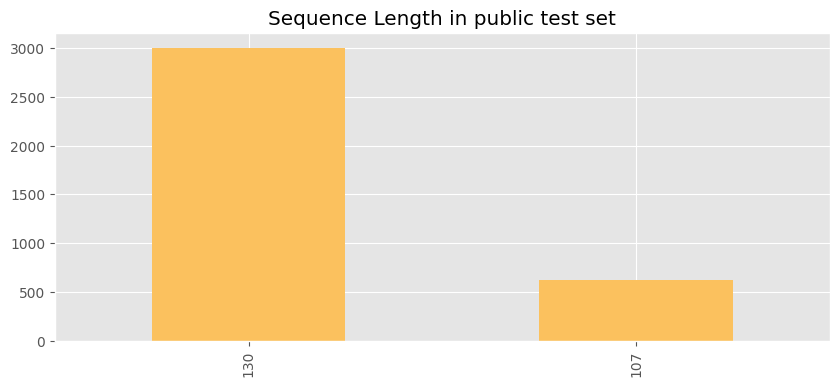

In [ ]:
test['seq_length'].value_counts() \
    .plot(kind='bar', figsize=(10, 4),
          color=color_pal[4],
         title='Sequence Length in public test set')
plt.show()

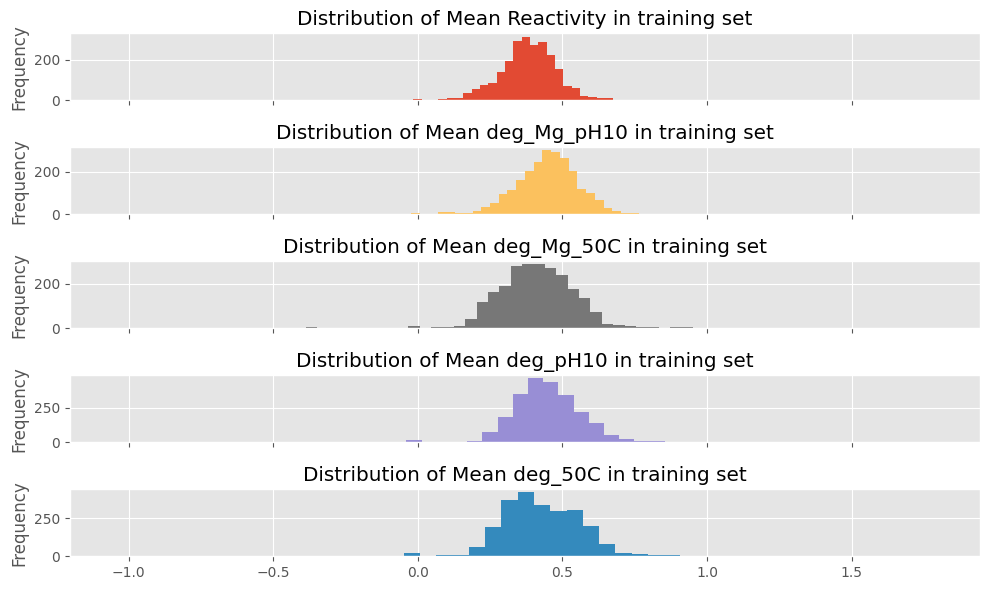

In [ ]:
fig, axs = plt.subplots(5, 1,
                        figsize=(10, 6),
                        sharex=True)
axs = axs.flatten()
train['mean_reactivity'] = train['reactivity'].apply(lambda x: np.mean(x))
train['mean_deg_Mg_pH10'] = train['deg_Mg_pH10'].apply(lambda x: np.mean(x))
train['mean_deg_Mg_50C'] = train['deg_Mg_50C'].apply(lambda x: np.mean(x))
#============== New Addition ======================
train['mean_deg_pH10'] = train['deg_pH10'].apply(lambda x: np.mean(x))
train['mean_deg_50C'] = train['deg_50C'].apply(lambda x: np.mean(x))

train['mean_reactivity'] \
    .plot(kind='hist',
          bins=50,
          color=color_pal[0],
          title='Distribution of Mean Reactivity in training set',
         ax=axs[0])
train['mean_deg_Mg_pH10'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          color=color_pal[4],
          title='Distribution of Mean deg_Mg_pH10 in training set')
train['mean_deg_Mg_50C'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          color=color_pal[3],
          title='Distribution of Mean deg_Mg_50C in training set')
#============== New Addition ======================
train['mean_deg_pH10'] \
    .plot(kind='hist',
          bins = 50,
          ax = axs[3],
          color=color_pal[2],
          title='Distribution of Mean deg_pH10 in training set')
train['mean_deg_50C'] \
    .plot(kind='hist',
          bins = 50,
          ax = axs[4],
          color=color_pal[1],
          title='Distribution of Mean deg_50C in training set')   
plt.tight_layout()
plt.show()

In [ ]:
mean_react = train['mean_reactivity'].mean()
mean_deg_Mg_pH10 = train['mean_deg_Mg_pH10'].mean()
mean_deg_Mg_50C = train['mean_deg_Mg_50C'].mean()
#============== New Addition ======================
mean_deg_pH10 = train['mean_deg_pH10'].mean()
mean_deg_50C = train['mean_deg_50C'].mean()

ss['reactivity'] = mean_react
ss['deg_Mg_pH10'] = mean_deg_Mg_pH10
ss['deg_Mg_50C'] = mean_deg_Mg_50C
#============== New Addition ======================
ss['deg_pH10'] = mean_deg_Mg_pH10
ss['deg_50C'] = mean_deg_50C

ss.to_csv('submission.csv', index=False)
ss.head()

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0  id_00073f8be_0    0.374922     0.446303  0.446303     0.40703  0.425889
1  id_00073f8be_1    0.374922     0.446303  0.446303     0.40703  0.425889
2  id_00073f8be_2    0.374922     0.446303  0.446303     0.40703  0.425889
3  id_00073f8be_3    0.374922     0.446303  0.446303     0.40703  0.425889
4  id_00073f8be_4    0.374922     0.446303  0.446303     0.40703  0.425889

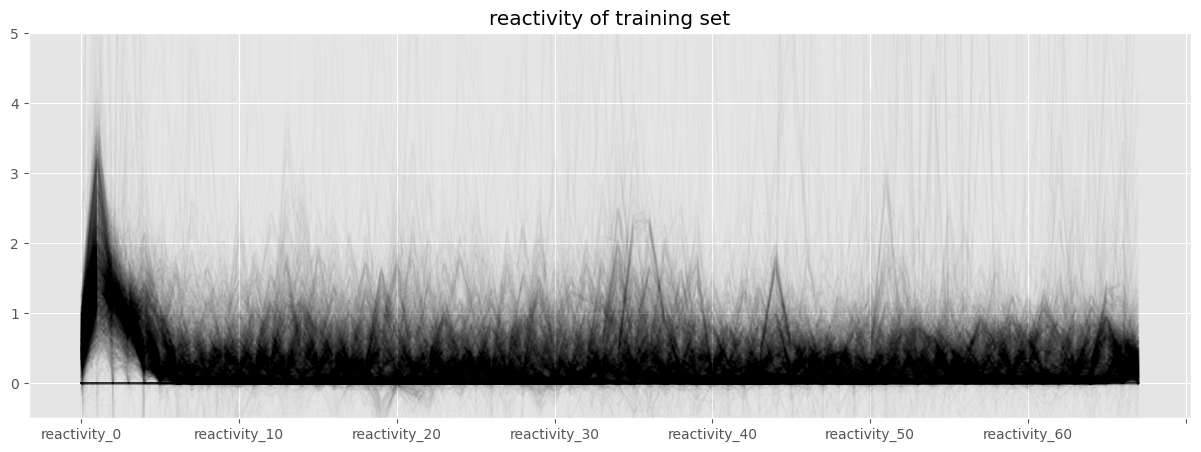

In [ ]:
for n in range(68):
    train[f'reactivity_{n}'] = train['reactivity'].apply(lambda x: x[n])
    
REACTIVITY_COLS = [r for r in train.columns if 'reactivity_' in r and 'error' not in r]

ax = train.set_index('id')[REACTIVITY_COLS] \
    .T \
    .plot(color='black',
          alpha=0.01,
          ylim=(-0.5, 5),
          title='reactivity of training set',
          figsize=(15, 5))
ax.get_legend().remove()

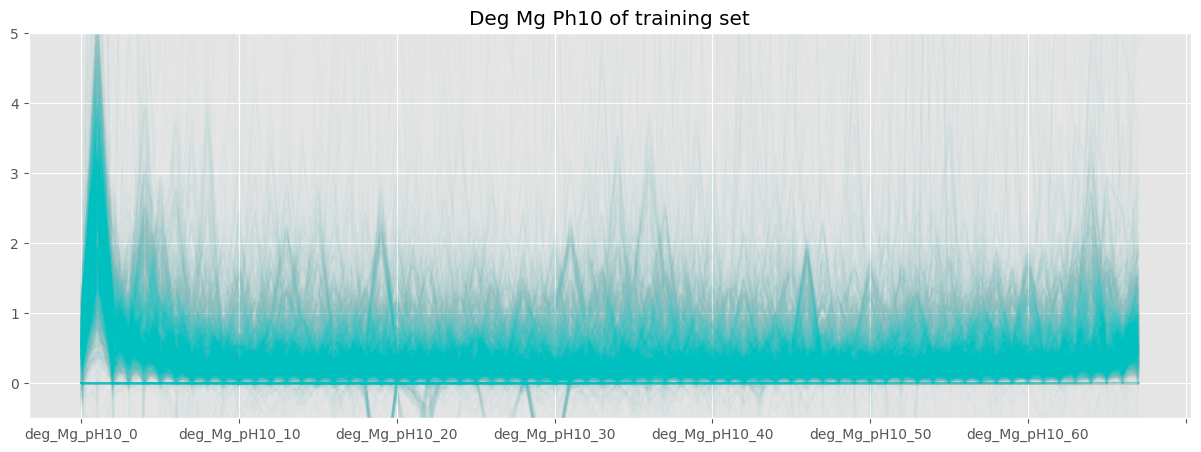

In [ ]:
for n in range(68):
    train[f'deg_Mg_pH10_{n}'] = train['deg_Mg_pH10'].apply(lambda x: x[n])
    
DEG_MG_PH10_COLS = [r for r in train.columns if 'deg_Mg_pH10_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_MG_PH10_COLS] \
    .T \
    .plot(color='c',
          alpha=0.01,
          ylim=(-0.5, 5),
          title='Deg Mg Ph10 of training set',
          figsize=(15, 5))
ax.get_legend().remove()

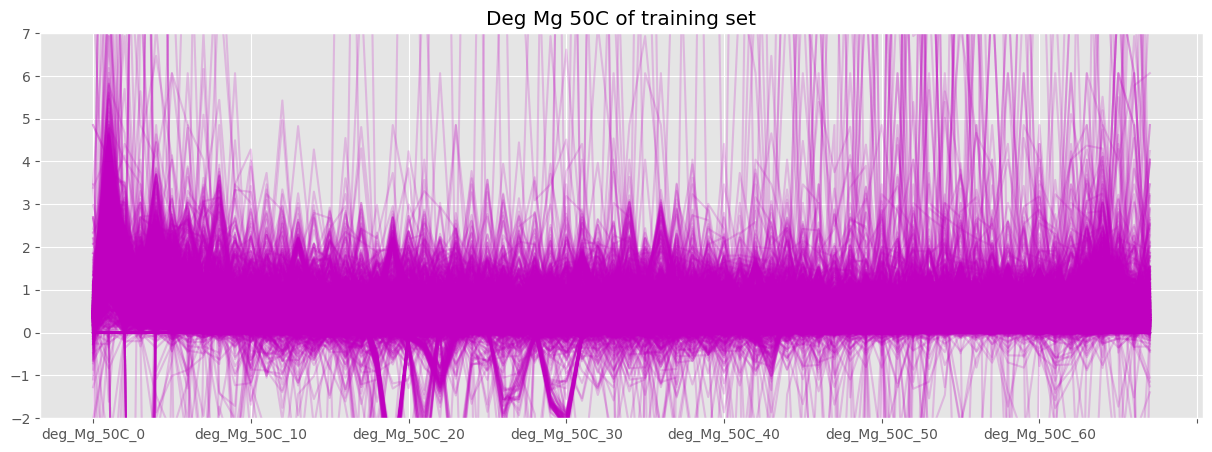

In [ ]:
for n in range(68):
    train[f'deg_Mg_50C_{n}'] = train['deg_Mg_50C'].apply(lambda x: x[n])
    
DEG_MG_50C_COLS = [r for r in train.columns if 'deg_Mg_50C_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_MG_50C_COLS] \
    .T \
    .plot(color='m',
          alpha=0.2,
          ylim=(-2, 7),
          title='Deg Mg 50C of training set',
          figsize=(15, 5)
         )
ax.get_legend().remove()

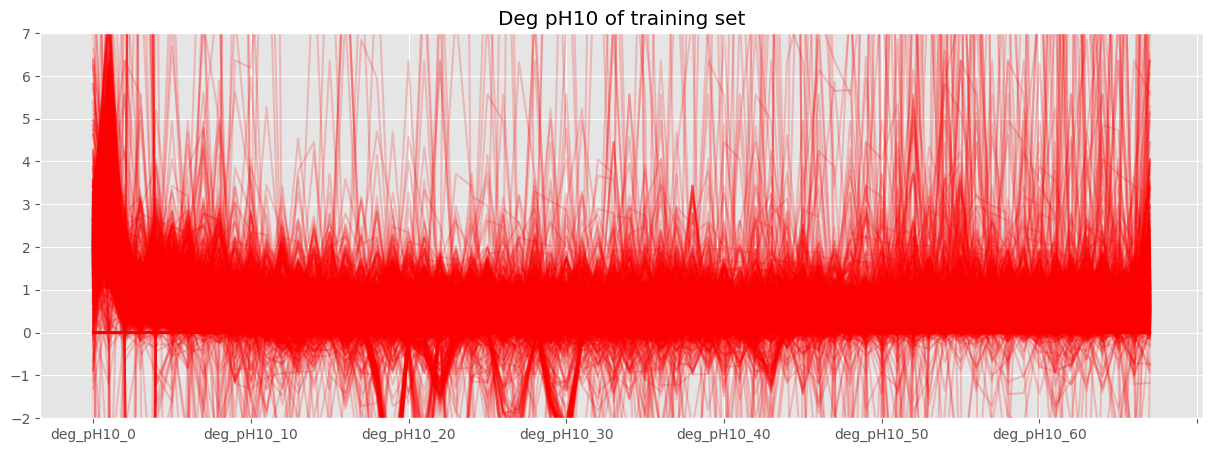

In [ ]:
#============== New Addition ======================
for n in range(68):
    train[f'deg_pH10_{n}'] = train['deg_pH10'].apply(lambda x: x[n])
    
DEG_PH10_COLS = [r for r in train.columns if 'deg_pH10_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_PH10_COLS] \
    .T \
    .plot(color='r',
          alpha=0.2,
          ylim=(-2, 7),
          title='Deg pH10 of training set',
          figsize=(15, 5)
         )
ax.get_legend().remove()

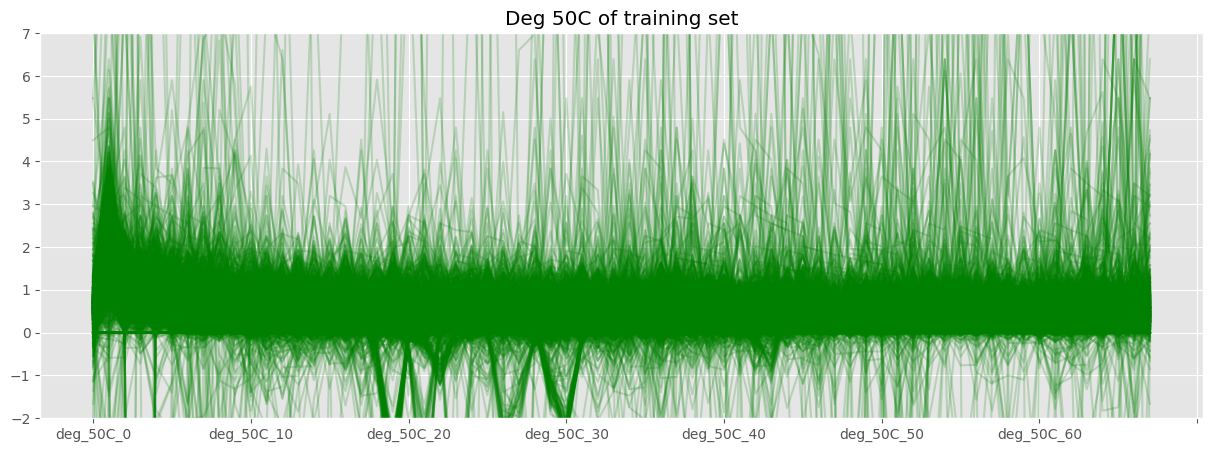

In [ ]:
#============== New Addition ======================
for n in range(68):
    train[f'deg_50C_{n}'] = train['deg_50C'].apply(lambda x: x[n])
    
DEG_50C_COLS = [r for r in train.columns if 'deg_50C_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_50C_COLS] \
    .T \
    .plot(color='g',
          alpha=0.2,
          ylim=(-2, 7),
          title='Deg 50C of training set',
          figsize=(15, 5)
         )
ax.get_legend().remove()

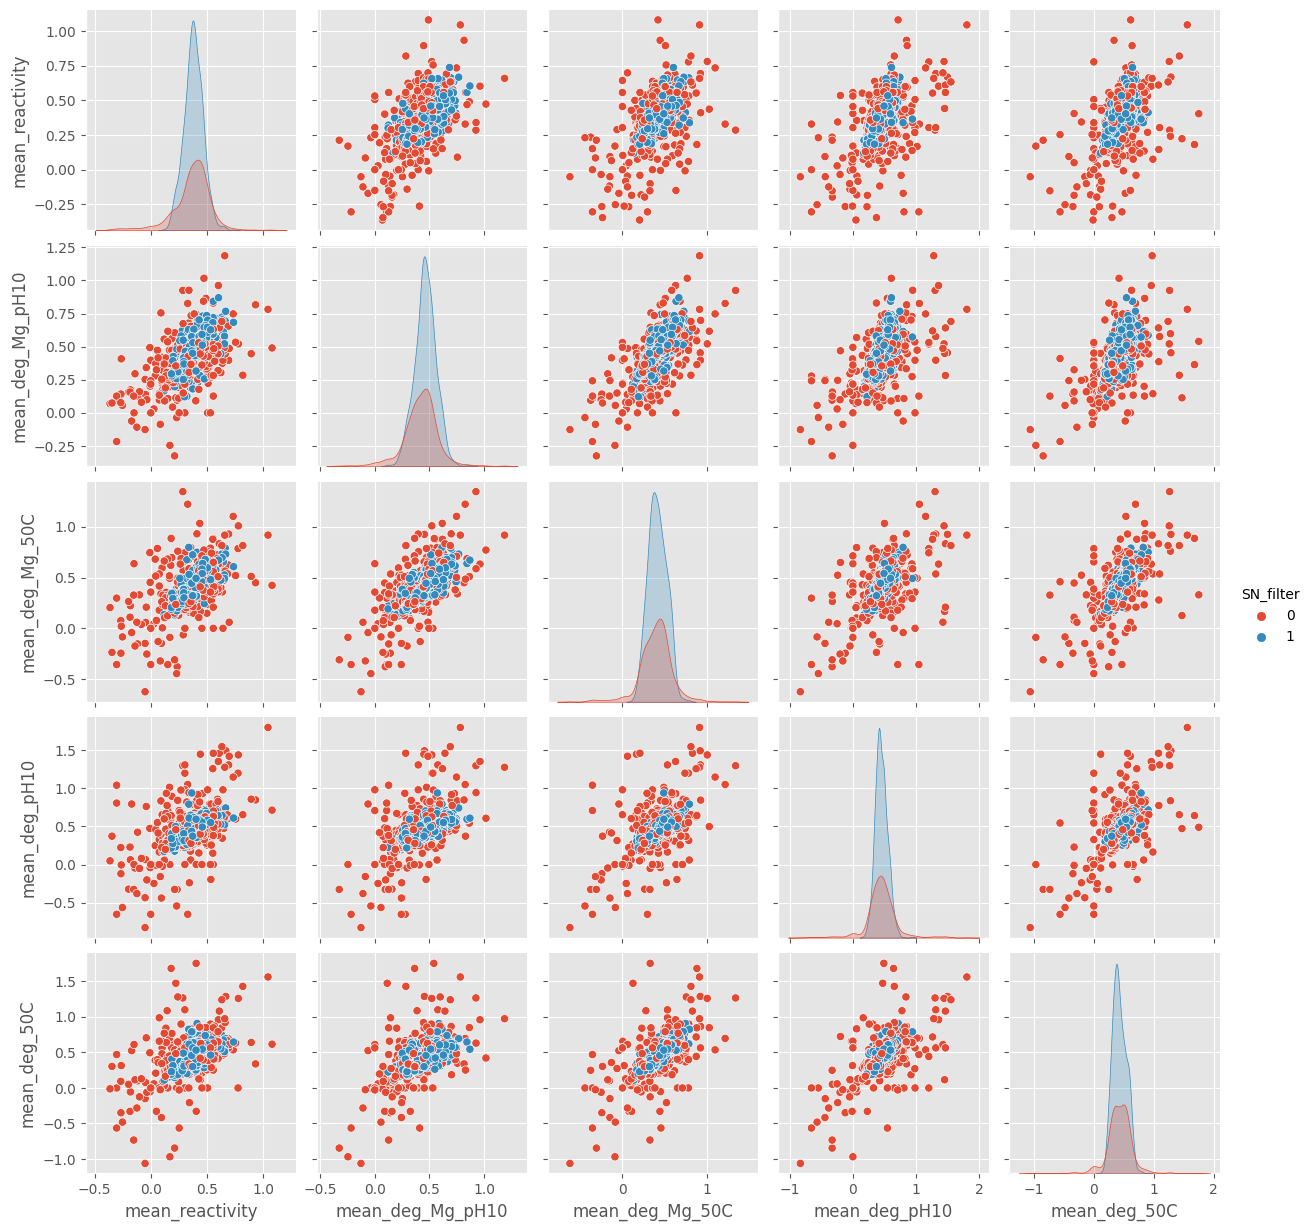

In [ ]:
sns.pairplot(data=train,
             vars=['mean_reactivity',
                   'mean_deg_Mg_pH10',
                   'mean_deg_Mg_50C',
                   #============== New Addition ======================
                   'mean_deg_pH10',
                   'mean_deg_50C'],
            hue='SN_filter')
plt.show()

In [ ]:
for n in range(107):
    train[f'sequence_{n}'] = train['sequence'].apply(lambda x: x[n]).astype('category')
    test[f'sequence_{n}'] = test['sequence'].apply(lambda x: x[n]).astype('category')

SEQUENCE_COLS = [c for c in train.columns if 'sequence_' in c]
#============== New Addition ======================
for target in ['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C']:

    X = train[SEQUENCE_COLS]
    y = train[f'mean_{target}']
    X_test = test[SEQUENCE_COLS]

    X_train, X_val, y_train, y_val = train_test_split(X, y)

    reg = lgb.LGBMRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=100,
            verbose=100)

    test[f'mean_{target}_pred'] = reg.predict(X_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0108497
Early stopping, best iteration is:
[30]	valid_0's l2: 0.0104422
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.00773225
Early stopping, best iteration is:
[55]	valid_0's l2: 0.00760564
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0129116
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0123984
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0241016
Early stopping, best iteration is:
[19]	valid_0's l2: 0.0208253
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0182964
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0176721


In [ ]:
ss['id_seqpos'].head()

0    id_00073f8be_0
1    id_00073f8be_1
2    id_00073f8be_2
3    id_00073f8be_3
4    id_00073f8be_4
Name: id_seqpos, dtype: object

In [ ]:
ss['id'] = 'id_' + ss['id_seqpos'].str.split('_', expand=True)[1]

# Merge my predicted average values
ss_new = ss. \
    drop(['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C'], axis=1) \
    .merge(test[['id',
               'mean_reactivity_pred',
               'mean_deg_Mg_pH10_pred',
               'mean_deg_Mg_50C_pred',
               #============== New Addition ======================
               'mean_deg_pH10_pred',
               'mean_deg_50C_pred']] \
               .rename(columns={'mean_reactivity_pred' : 'reactivity',
                                'mean_deg_Mg_pH10_pred': 'deg_Mg_pH10',
                                'mean_deg_Mg_50C_pred' : 'deg_Mg_50C',
                                #============== New Addition ======================
                                'mean_deg_pH10_pred' : 'deg_pH10',
                                'mean_deg_50C_pred' : 'deg_50C'},
                      ),
         on='id',
        validate='m:1')

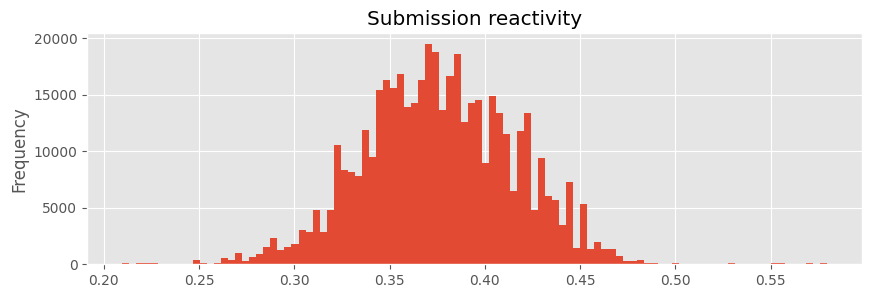

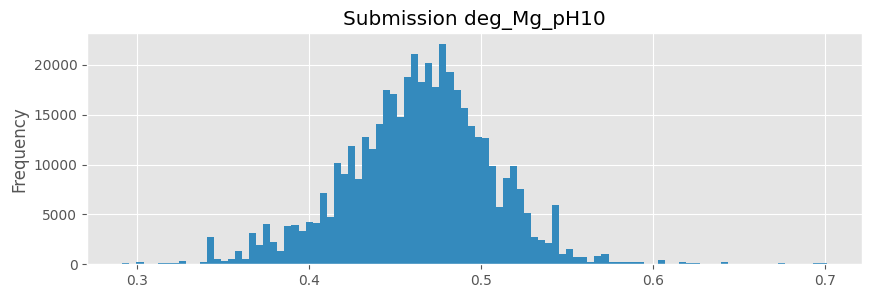

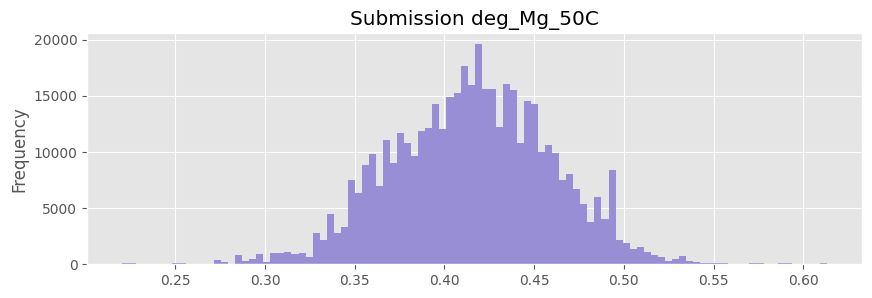

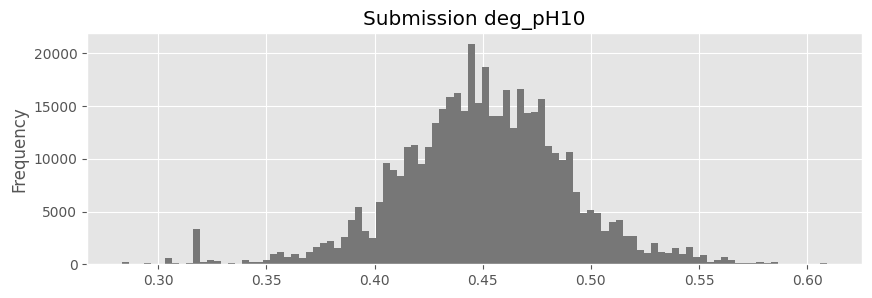

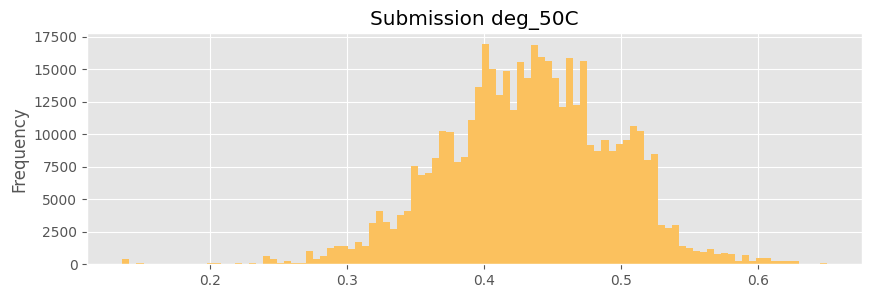

In [ ]:
#============== New Addition ======================
TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C']
for i, t in enumerate(TARGETS):
    ss_new[t].plot(kind='hist',
                   figsize=(10, 3),
                   bins=100,
                   color=color_pal[i],
                   title=f'Submission {t}')
    plt.show()

In [ ]:
ss_new.sample(10)

id_seqpos            id  reactivity  deg_Mg_pH10  deg_Mg_50C  \
334194  id_b750a3a31_129  id_b750a3a31    0.337890     0.471658    0.416385   
392672    id_d81232765_5  id_d81232765    0.373379     0.545568    0.414155   
171948  id_5b627cbf2_117  id_5b627cbf2    0.385820     0.485304    0.387558   
164223  id_58577f91e_107  id_58577f91e    0.345323     0.471251    0.419688   
304696   id_a6d2e2fe0_24  id_a6d2e2fe0    0.373321     0.474708    0.371453   
218311   id_755fa0280_58  id_755fa0280    0.354134     0.417523    0.419686   
28515    id_0dc8a1479_17  id_0dc8a1479    0.351666     0.499278    0.417863   
32846     id_1046eca55_5  id_1046eca55    0.442739     0.439396    0.416559   
390707    id_d6986f624_5  id_d6986f624    0.398447     0.464655    0.427529   
91133    id_30055b674_95  id_30055b674    0.410275     0.501023    0.453490   

        deg_pH10   deg_50C  
334194  0.446562  0.518830  
392672  0.473131  0.408934  
171948  0.427735  0.463753  
164223  0.452323  0.490938  
304696  0.468177  0.450534  
218311  0.455320  0.382714  
28515   0.425818  0.434415  
32846   0.404564  0.521114  
390707  0.482135  0.487301  
91133   0.534433  0.503482

In [ ]:
# Make Submission
ss = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')
ss_new[ss.columns].to_csv('submission_lgbm_v1.csv', index=False)

Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's l2: 0.0100573
[2000]	valid_0's l2: 0.00837782
[3000]	valid_0's l2: 0.0077083
[4000]	valid_0's l2: 0.0073945
[5000]	valid_0's l2: 0.00723516
[6000]	valid_0's l2: 0.00716038
[7000]	valid_0's l2: 0.00712986
Early stopping, best iteration is:
[7696]	valid_0's l2: 0.00710937
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's l2: 0.00964041
[2000]	valid_0's l2: 0.00860907
[3000]	valid_0's l2: 0.00832277
[4000]	valid_0's l2: 0.00825016
[5000]	valid_0's l2: 0.00816452
[6000]	valid_0's l2: 0.00810247
[7000]	valid_0's l2: 0.0080705
Early stopping, best iteration is:
[7037]	valid_0's l2: 0.00807033
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's l2: 0.0128527
[2000]	valid_0's l2: 0.0113021
[3000]	valid_0's l2: 0.01071
[4000]	valid_0's l2: 0.0104272
[5000]	valid_0's l2: 0.0103106
[6000]	valid_0's l2: 0.0102429
[7000]	valid_0's l2: 0.0101777
[8000]	valid_0's l

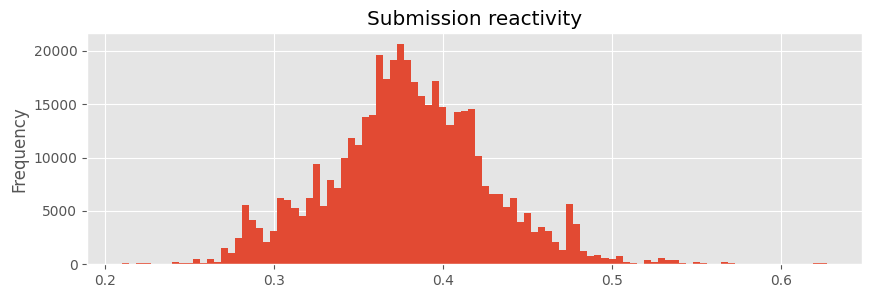

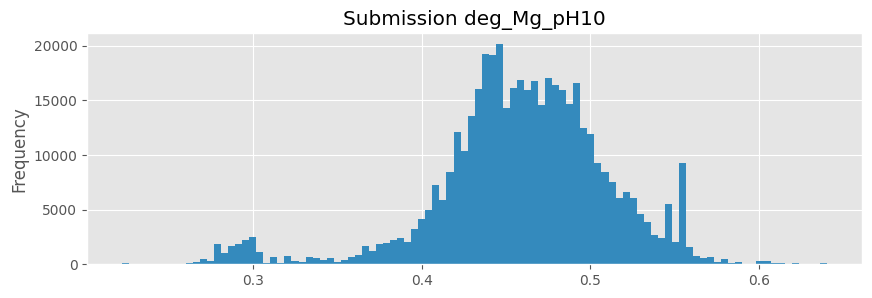

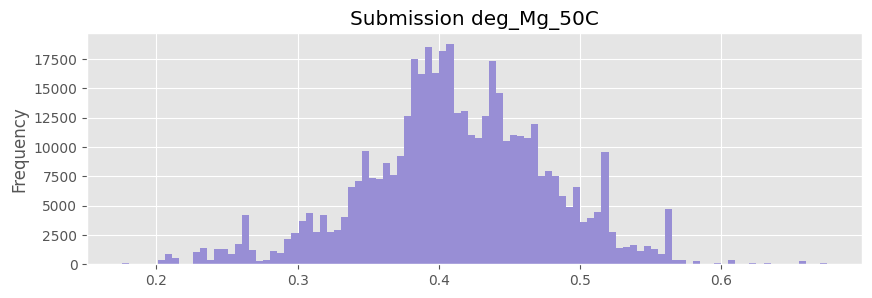

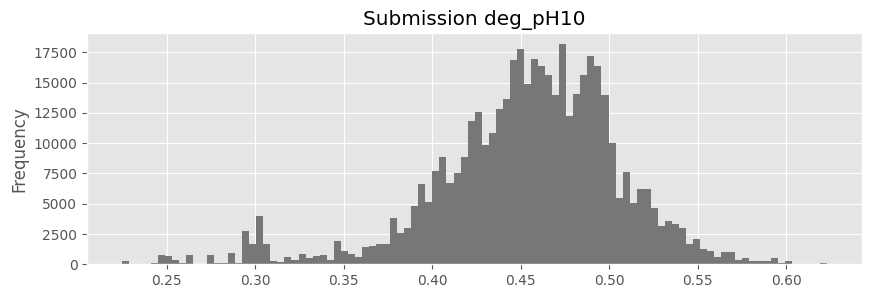

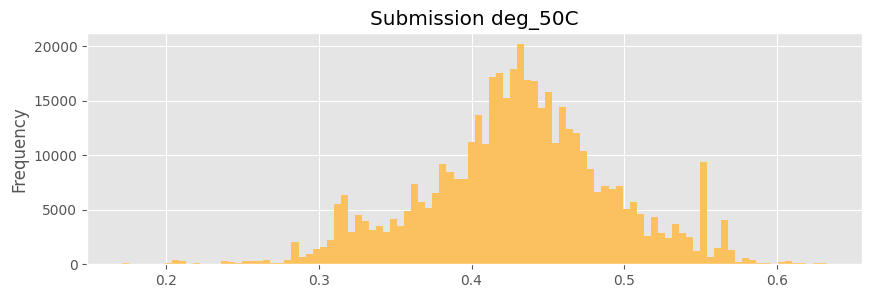

In [ ]:
# Expand Sequence Features
for n in range(107):
    train[f'structure_{n}'] = train['structure'].apply(lambda x: x[n]).astype('category')
    test[f'structure_{n}'] = test['structure'].apply(lambda x: x[n]).astype('category')
    train[f'predicted_loop_type_{n}'] = train['predicted_loop_type'].apply(lambda x: x[n]).astype('category')
    test[f'predicted_loop_type_{n}'] = test['predicted_loop_type'].apply(lambda x: x[n]).astype('category')
    train[f'sequence_{n}'] = train['sequence'].apply(lambda x: x[n]).astype('category')
    test[f'sequence_{n}'] = test['sequence'].apply(lambda x: x[n]).astype('category')

SEQUENCE_COLS = [c for c in train.columns if 'sequence_' in c]
STRUCTURE_COLS = [c for c in train.columns if 'structure_' in c]
PLT_COLS = [c for c in train.columns if 'predicted_loop_type_' in c]
#============== New Addition ======================
for target in ['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C']:

    X = train[SEQUENCE_COLS + STRUCTURE_COLS + PLT_COLS]
    y = train[f'mean_{target}']
    X_test = test[SEQUENCE_COLS + STRUCTURE_COLS + PLT_COLS]

    X_train, X_val, y_train, y_val = train_test_split(X, y)

    reg = lgb.LGBMRegressor(n_estimators=10000,
                            learning_rate=0.001,
                            feature_fraction=0.8)
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=100,
            verbose=1000)

    test[f'mean_{target}_pred'] = reg.predict(X_test)
    
ss['id'] = 'id_' + ss['id_seqpos'].str.split('_', expand=True)[1]

# Merge my predicted average values
#============== New Addition ======================
ss_new = ss. \
    drop(['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C'], axis=1) \
    .merge(test[['id',
               'mean_reactivity_pred',
               'mean_deg_Mg_pH10_pred',
               'mean_deg_Mg_50C_pred',
               #============== New Addition ======================
               'mean_deg_pH10_pred',
               'mean_deg_50C_pred']] \
               .rename(columns={'mean_reactivity_pred' : 'reactivity',
                                'mean_deg_Mg_pH10_pred': 'deg_Mg_pH10',
                                'mean_deg_Mg_50C_pred' : 'deg_Mg_50C',
                                #============== New Addition ======================
                                'mean_deg_pH10_pred' : 'deg_pH10',
                                'mean_deg_50C_pred' : 'deg_50C'}
                      ),
         on='id',
        validate='m:1')

ss = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')
ss_new[ss.columns].to_csv('/content/drive/MyDrive/MRNA-vaccine/submission.csv', index=False)
#============== New Addition ======================
TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C']
for i, t in enumerate(TARGETS):
    ss_new[t].plot(kind='hist',
                              figsize=(10, 3),
                              bins=100,
                              color=color_pal[i],
                              title=f'Submission {t}')
    plt.show()


In [ ]:
REACTIVITY_COLS

['reactivity_0',
 'reactivity_1',
 'reactivity_2',
 'reactivity_3',
 'reactivity_4',
 'reactivity_5',
 'reactivity_6',
 'reactivity_7',
 'reactivity_8',
 'reactivity_9',
 'reactivity_10',
 'reactivity_11',
 'reactivity_12',
 'reactivity_13',
 'reactivity_14',
 'reactivity_15',
 'reactivity_16',
 'reactivity_17',
 'reactivity_18',
 'reactivity_19',
 'reactivity_20',
 'reactivity_21',
 'reactivity_22',
 'reactivity_23',
 'reactivity_24',
 'reactivity_25',
 'reactivity_26',
 'reactivity_27',
 'reactivity_28',
 'reactivity_29',
 'reactivity_30',
 'reactivity_31',
 'reactivity_32',
 'reactivity_33',
 'reactivity_34',
 'reactivity_35',
 'reactivity_36',
 'reactivity_37',
 'reactivity_38',
 'reactivity_39',
 'reactivity_40',
 'reactivity_41',
 'reactivity_42',
 'reactivity_43',
 'reactivity_44',
 'reactivity_45',
 'reactivity_46',
 'reactivity_47',
 'reactivity_48',
 'reactivity_49',
 'reactivity_50',
 'reactivity_51',
 'reactivity_52',
 'reactivity_53',
 'reactivity_54',
 'reactivity_55',
 '

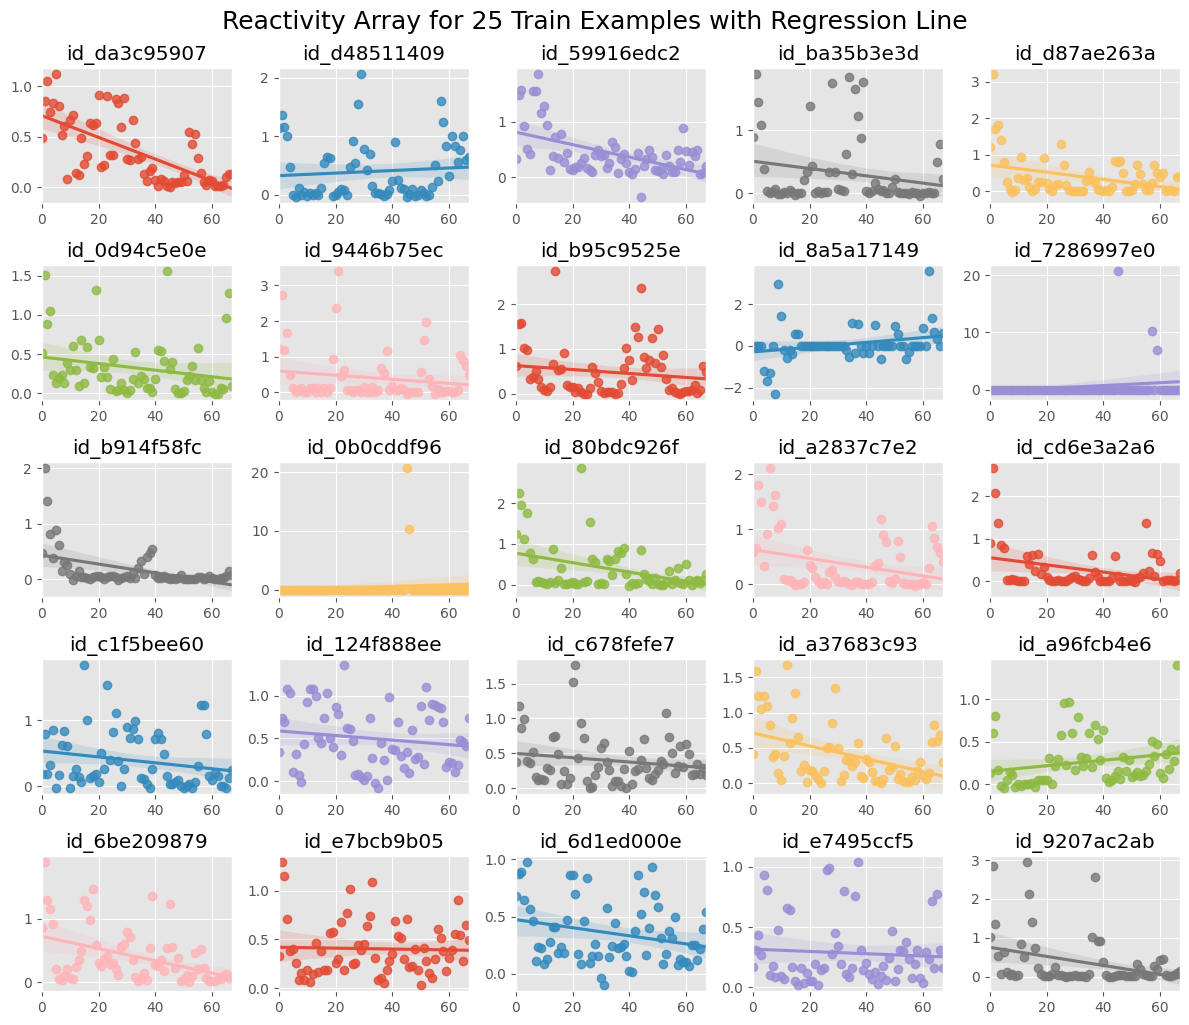

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()  #axs.shape = 25
i = 0

for row in train.sample(n=25, random_state=42).iterrows():
  myid = row[1]['id']
  reactivity_array = row[1][REACTIVITY_COLS].values # 68 values
  
  #reactivity_array = np.nan_to_num(reactivity_array)
  reactivity_array = np.array(reactivity_array, dtype=float)
 
  sns.regplot(x=np.array(range(68)),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))

  axs[i].set_title(myid)
  i += 1

fig.suptitle('Reactivity Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

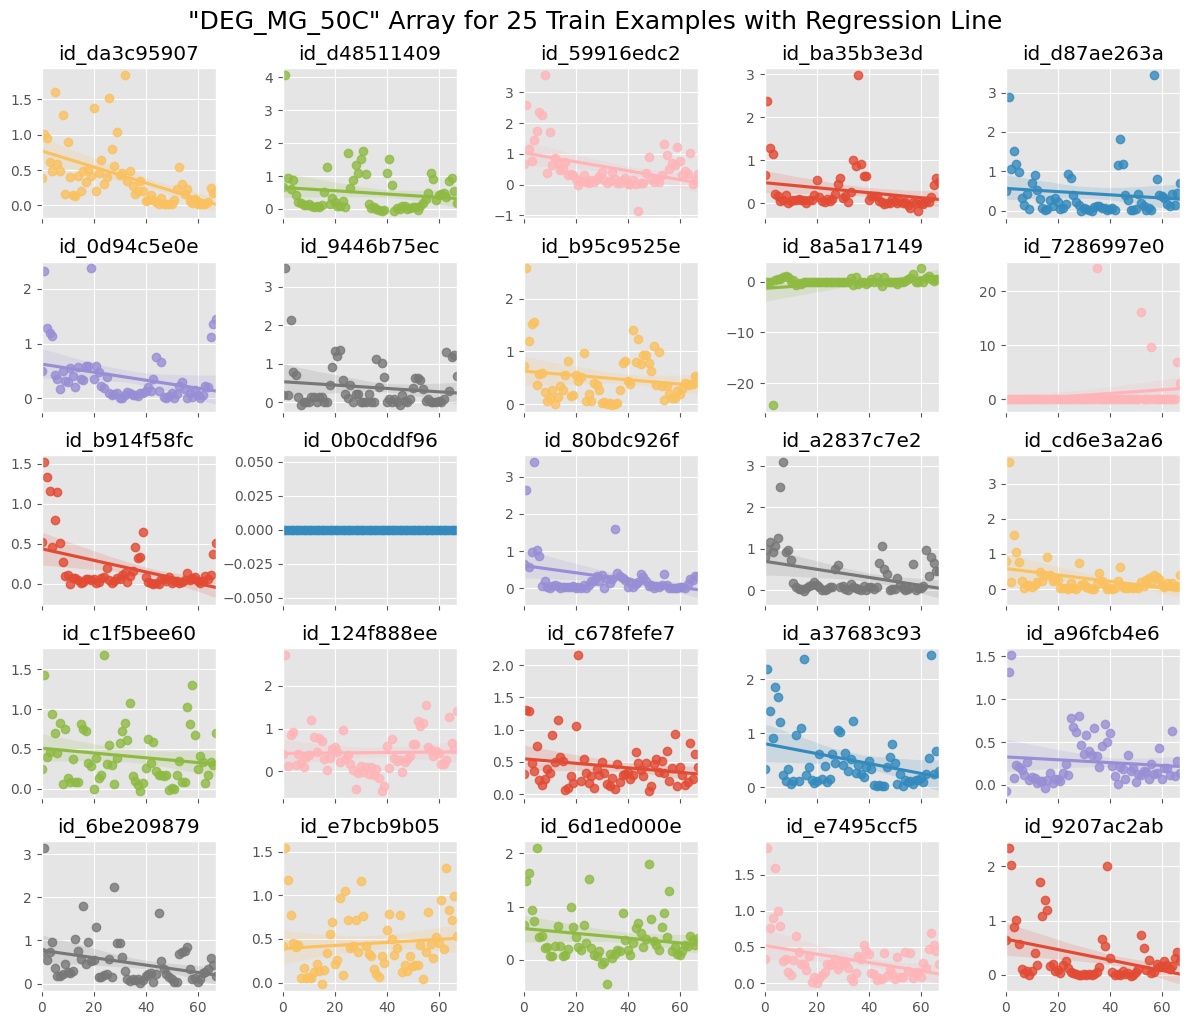

In [ ]:
fig, axs = plt.subplots(5, 5,
                        figsize=(12, 10),
                        sharex=True)
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_MG_50C_COLS].values
    reactivity_array = np.array(reactivity_array, dtype=float)
    sns.regplot(x=np.array(range(68)).reshape(-1, 1),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_MG_50C" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()


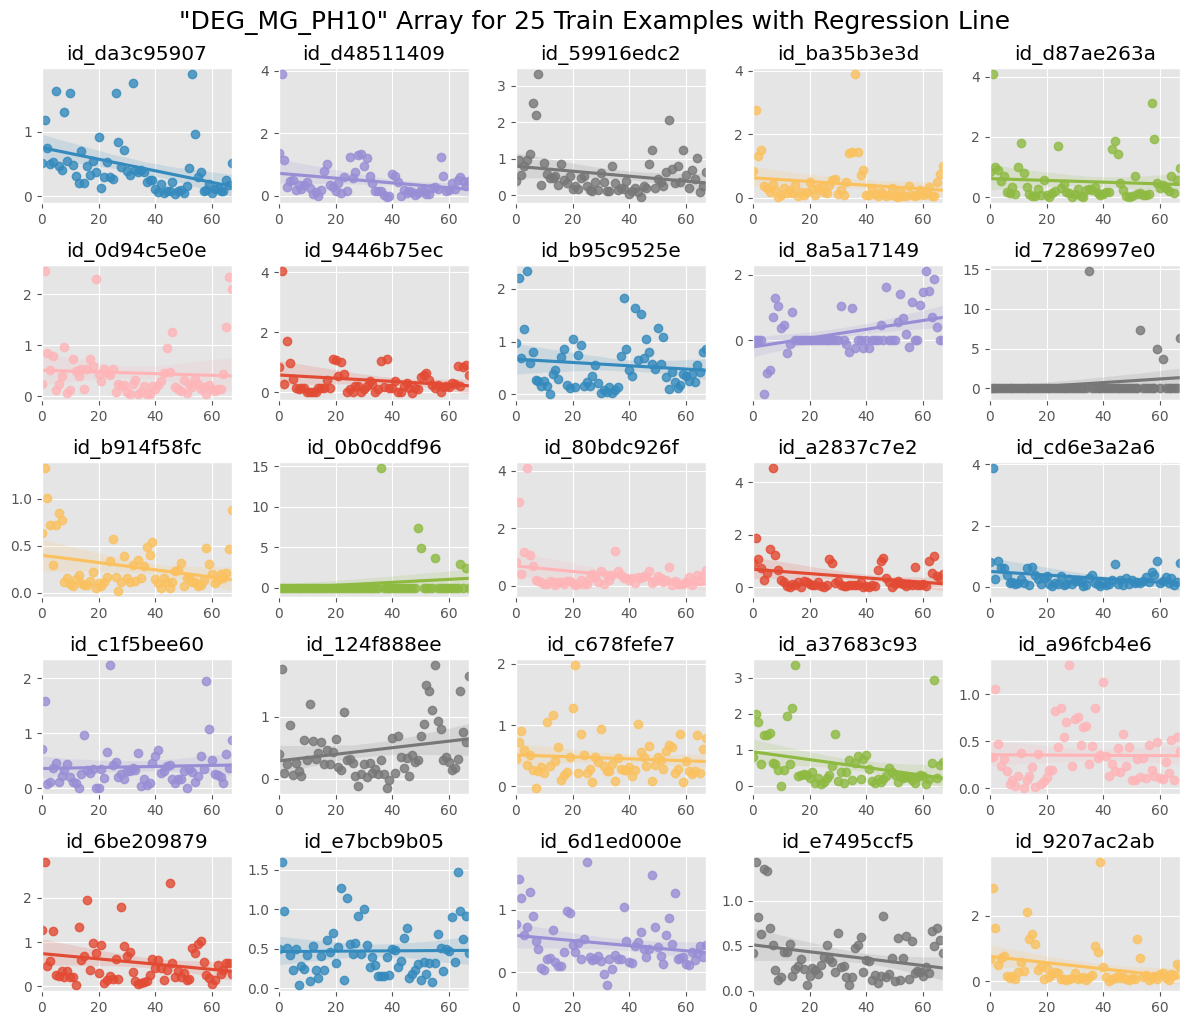

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_MG_PH10_COLS].values
    reactivity_array = np.array(reactivity_array, dtype=float)
    sns.regplot(x=np.array(range(68)).reshape(-1, 1),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_MG_PH10" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

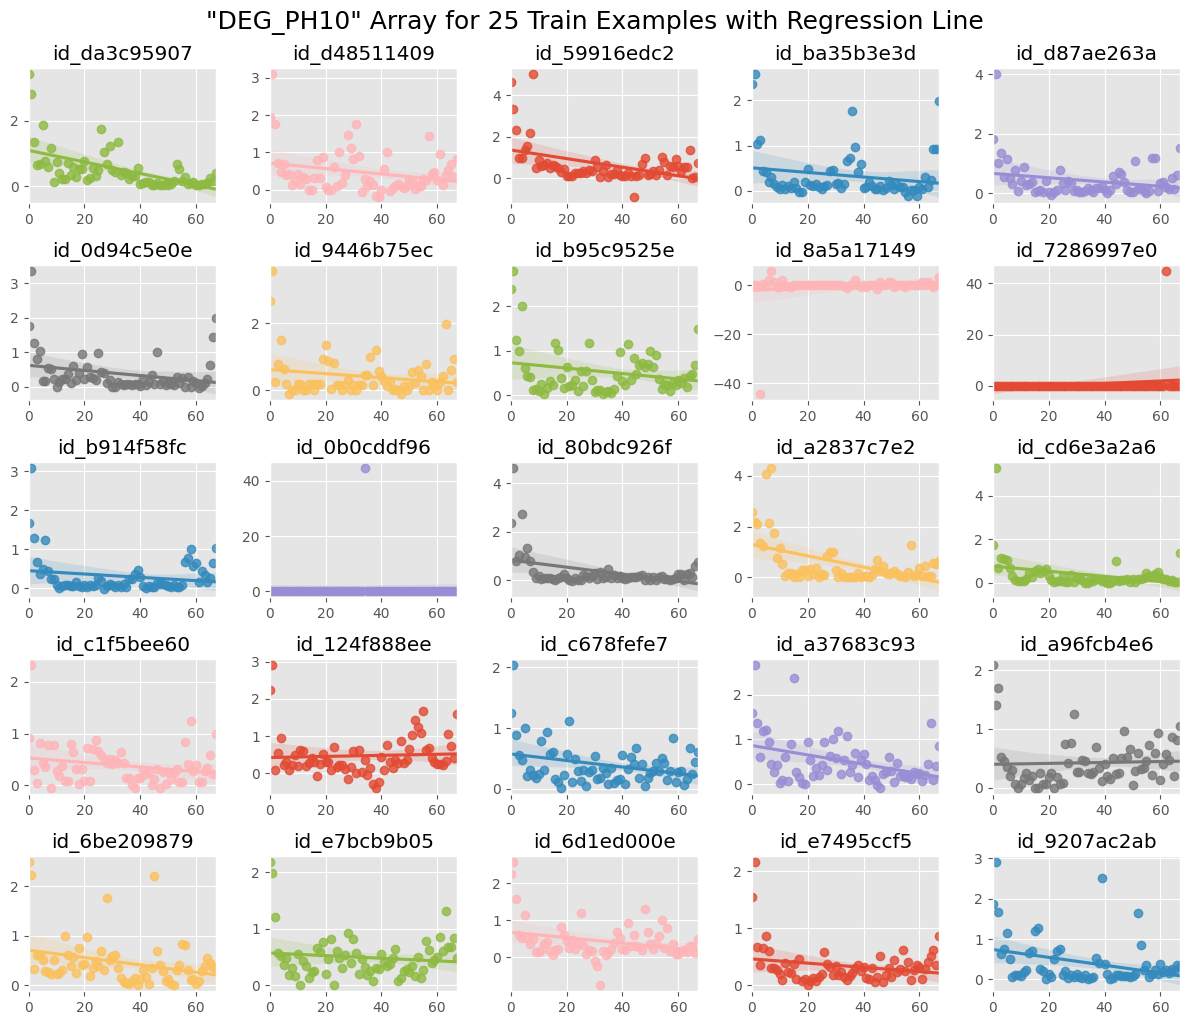

In [ ]:
#============== New Addition ======================
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_PH10_COLS].values
    reactivity_array = np.array(reactivity_array, dtype=float)
    sns.regplot(x=np.array(range(68)).reshape(-1, 1),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_PH10" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

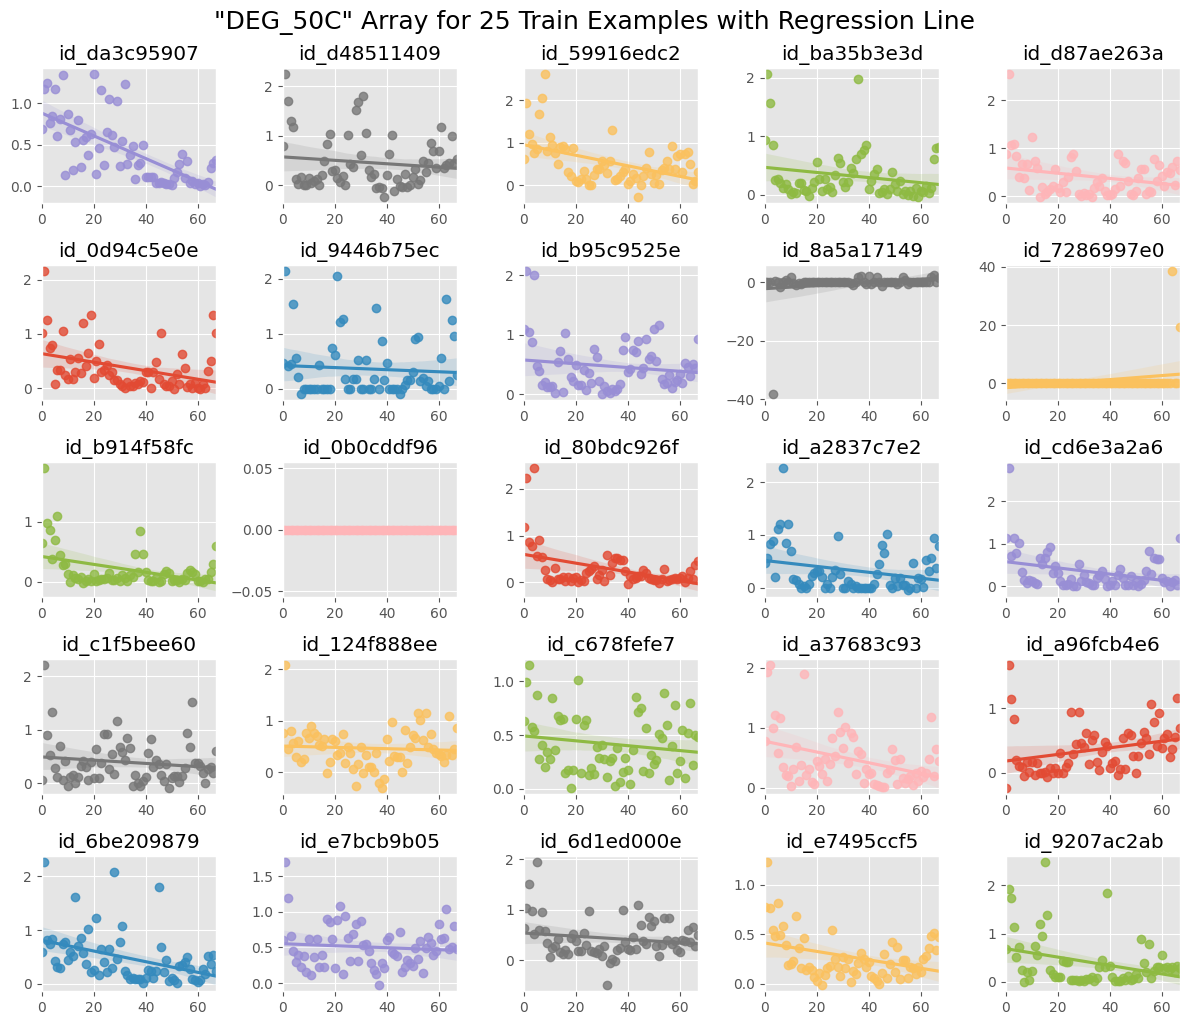

In [ ]:
#============== New Addition ======================
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_50C_COLS].values
    reactivity_array = np.array(reactivity_array, dtype=float)
    sns.regplot(x=np.array(range(68)).reshape(-1, 1),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_50C" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

**Section 2: Better LGBM Regressor**

In [ ]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pylab as plt

def expand_columns(df):
    df = df.copy()
    df = df.drop('index', axis=1)
    max_seq_length = df['seq_length'].max()
    SEQUENCE_COLS = []; STRUCTURE_COLS = []; PRED_LOOP_TYPE_COLS = []
    for s in range(130):
        df[f'sequence_{s}'] = df['sequence'].str[s]
        df[f'structure_{s}'] = df['structure'].str[s]
        df[f'predicted_loop_type_{s}'] = df['predicted_loop_type'].str[s]
        SEQUENCE_COLS.append(f'sequence_{s}')
        STRUCTURE_COLS.append(f'structure_{s}')
    return df, SEQUENCE_COLS, STRUCTURE_COLS

def parse_sample_submission(ss):
    ss = ss.copy()
    ss['id'] = ss['id_seqpos'].str.split('_', expand=True)[1]
    ss['seqpos'] = ss['id_seqpos'].str.split('_', expand=True)[2].astype('int')
    return ss

In [ ]:
def get_train_long(train):
    dfs = []

    def pad(feat, tolen):
        padded = np.pad(feat,
                        (0, tolen-len(feat)),
                        mode='constant',
                        constant_values=np.nan)
        return padded

    for d in tqdm(train.itertuples(), total=len(train)):
        #print('d=', d)
        sequence = [s for s in d[3]]
        seq_len = len(sequence)
        structure = [s for s in d[4]]
        predicted_loop_type = [s for s in d[5]]
        reactivity_error = pad([s for s in d[10]], seq_len)
        deg_error_Mg_pH10 = pad([s for s in d[11]], seq_len)
        deg_error_pH10 = pad([s for s in d[12]], seq_len)
        deg_error_Mg_50C = pad([s for s in d[13]], seq_len)
        deg_error_50C = pad([s for s in d[14]], seq_len)

        reactivity = pad([s for s in d[15]], seq_len)
        deg_Mg_pH10 = pad([s for s in d[16]], seq_len)
        deg_pH10 = pad([s for s in d[17]], seq_len)
        deg_Mg_50C = pad([s for s in d[18]], seq_len)
        deg_50C = pad([s for s in d[10]], seq_len)
        myid = [d[2]] * len(sequence)
        seqpos = [c for c in range(len(sequence))]
        dfs.append(pd.DataFrame(np.array([myid,
                                          seqpos,
                                          sequence,
                                          structure,
                                          predicted_loop_type,
                                          reactivity_error,
                                          deg_error_Mg_pH10,
                                          deg_error_pH10,
                                          deg_error_Mg_50C,
                                          deg_error_50C,
                                          reactivity,
                                          deg_Mg_pH10,
                                          deg_pH10,
                                          deg_Mg_50C,
                                          deg_50C
                                         ]).T))
    train_long = pd.concat(dfs)

    train_long.columns=['id',
               'seqpos',
               'sequence',
               'structure',
               'predicted_loop_type',
               'reactivity_error',
               'deg_error_Mg_pH10',
               'deg_error_pH10',
               'deg_error_Mg_50C',
               'deg_error_50C',
               'reactivity',
               'deg_Mg_pH10',
               'deg_pH10',
               'deg_Mg_50C',
               'deg_50C']

    return train_long


def get_test_long(test):
    dfs = []

    def pad(feat, tolen):
        padded = np.pad(feat,
                        (0, tolen-len(feat)),
                        mode='constant',
                        constant_values=np.nan)
        return padded

    for d in tqdm(test.itertuples(), total=len(test)):
        sequence = [s for s in d[3]]
        seq_len = len(sequence)
        structure = [s for s in d[4]]
        predicted_loop_type = [s for s in d[5]]
        myid = [d[2]] * len(sequence)
        seqpos = [c for c in range(len(sequence))]
        dfs.append(pd.DataFrame(np.array([myid,
                                          seqpos,
                                          sequence,
                                          structure,
                                          predicted_loop_type,
                                         ]).T))
    test_long = pd.concat(dfs)

    test_long.columns=['id',
               'seqpos',
               'sequence',
               'structure',
               'predicted_loop_type']

    return test_long

def add_long_features(df):
    df = df.copy()
    df['seqpos'] = df['seqpos'].astype('int')
    df = df.merge(df.query('seqpos <= 106') \
                    .groupby('id')['sequence'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )
    
    df = df.merge(df.query('seqpos <= 106') \
                  .groupby('id')['structure'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )

    df = df.merge(df.query('seqpos <= 106') \
                  .groupby('id')['predicted_loop_type'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )
    for shift in [-5, -4, -3, -2 -1, 1, 2, 3, 4, 5]:
        for f in ['sequence','structure','predicted_loop_type']:
            df[f'{f}_shift{shift}'] = df.groupby('id')[f].shift(shift)
    return df

In [ ]:
def make_feature_types(df, features):
    df = df.copy()
    df = df.replace('nan', np.nan)
    for f in features:
        try:
            df[f] = pd.to_numeric(df[f])
        except ValueError:
            df[f] = df[f].astype('category')
    return df

In [ ]:
train = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/train.json', lines=True)
test = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/test.json', lines=True)
ss = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')

train_expanded, SEQUENCE_COLS, STRUCTURE_COLS = expand_columns(train)
test_expanded, SEQUENCE_COLS, STRUCTURE_COLS = expand_columns(test)
ss = parse_sample_submission(ss)

train_long = get_train_long(train)
test_long = get_test_long(test)

train_long = add_long_features(train_long)
print('train_long columns: ', train_long.columns)
test_long = add_long_features(test_long)

FEATURES = ['seqpos',
            'sequence',
            'structure',
            'predicted_loop_type',
            'A', 'C', 'G', 'U', '(', ')', '.', 'B', 'E',
            'H', 'I', 'M', 'S', 'X',
            'sequence_shift-5', 'structure_shift-5',
            'predicted_loop_type_shift-5', 'sequence_shift-4', 'structure_shift-4',
            'predicted_loop_type_shift-4', 'sequence_shift-3', 'structure_shift-3',
            'predicted_loop_type_shift-3', 'sequence_shift1', 'structure_shift1',
            'predicted_loop_type_shift1', 'sequence_shift2', 'structure_shift2',
            'predicted_loop_type_shift2', 'sequence_shift3', 'structure_shift3',
            'predicted_loop_type_shift3', 'sequence_shift4', 'structure_shift4',
            'predicted_loop_type_shift4', 'sequence_shift5', 'structure_shift5',
            'predicted_loop_type_shift5']

train_long = make_feature_types(train_long, FEATURES)

#print('Here = ', train_long.columns)

test_long = make_feature_types(test_long, FEATURES)

train_ids, val_ids = train_test_split(train['id'].unique())
#============== New Addition ======================
TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C']


train_long columns:  Index(['id', 'seqpos', 'sequence', 'structure', 'predicted_loop_type',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'A', 'C', 'G', 'U', '(', ')', '.',
       'B', 'E', 'H', 'I', 'M', 'S', 'X', 'sequence_shift-5',
       'structure_shift-5', 'predicted_loop_type_shift-5', 'sequence_shift-4',
       'structure_shift-4', 'predicted_loop_type_shift-4', 'sequence_shift-3',
       'structure_shift-3', 'predicted_loop_type_shift-3', 'sequence_shift1',
       'structure_shift1', 'predicted_loop_type_shift1', 'sequence_shift2',
       'structure_shift2', 'predicted_loop_type_shift2', 'sequence_shift3',
       'structure_shift3', 'predicted_loop_type_shift3', 'sequence_shift4',
       'structure_shift4', 'predicted_loop_type_shift4', 'sequence_shift5',
       'structure_shift5', 'predicted_loop_type_shift5'],
      dtype='object')


Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.510428


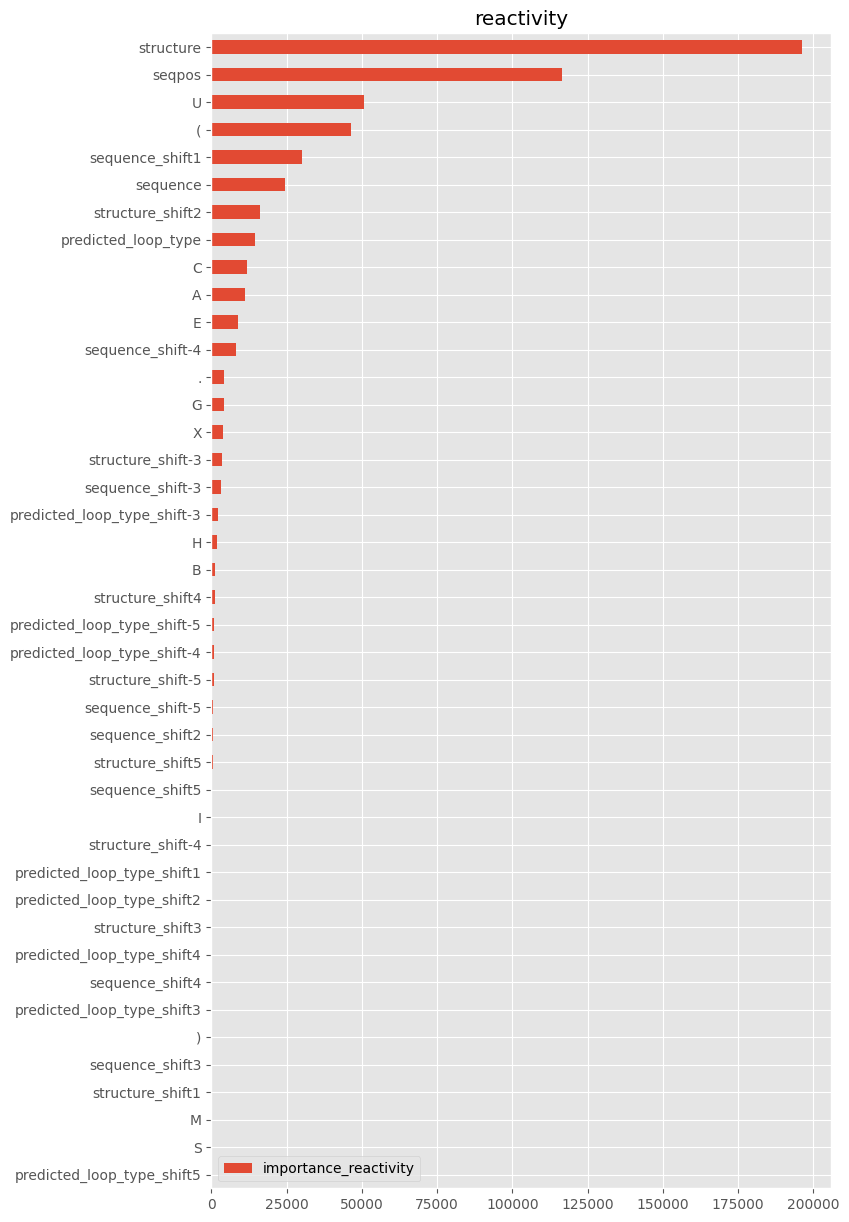

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.479042


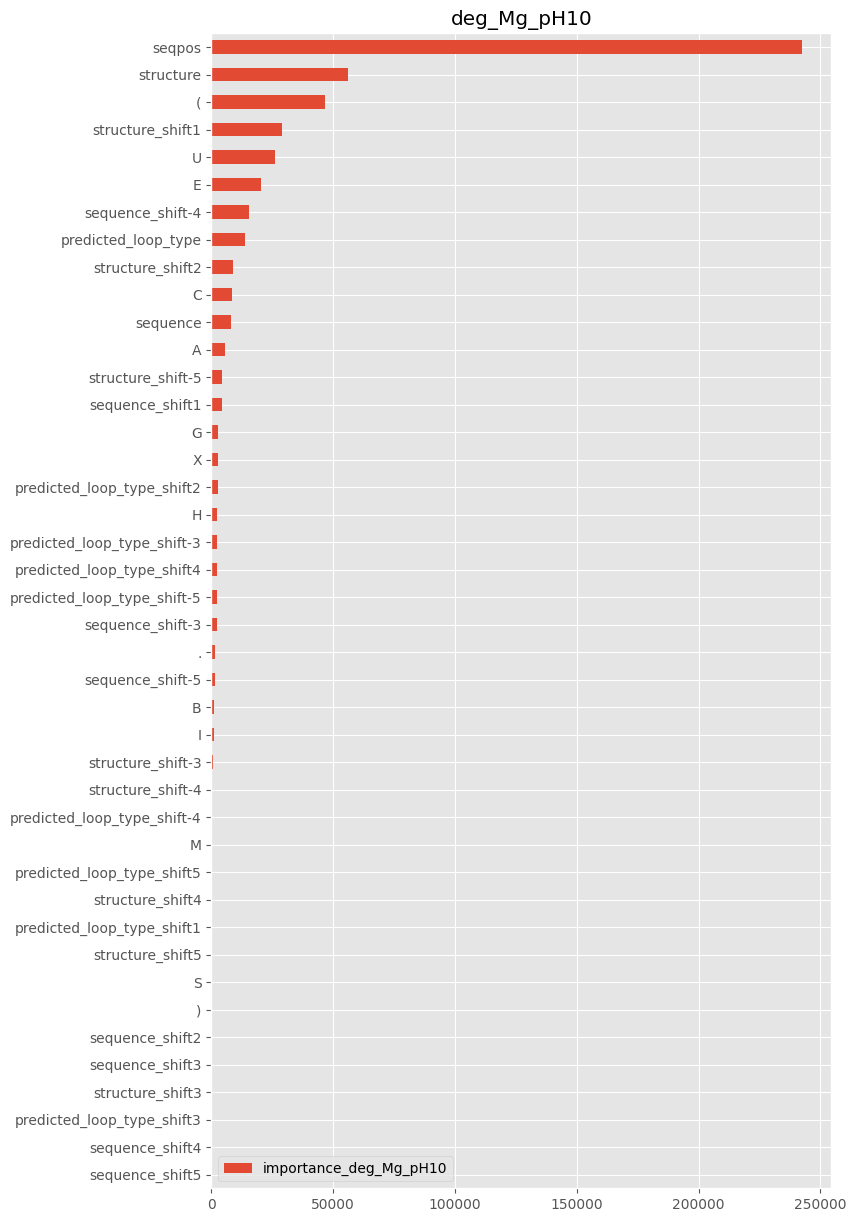

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.833856


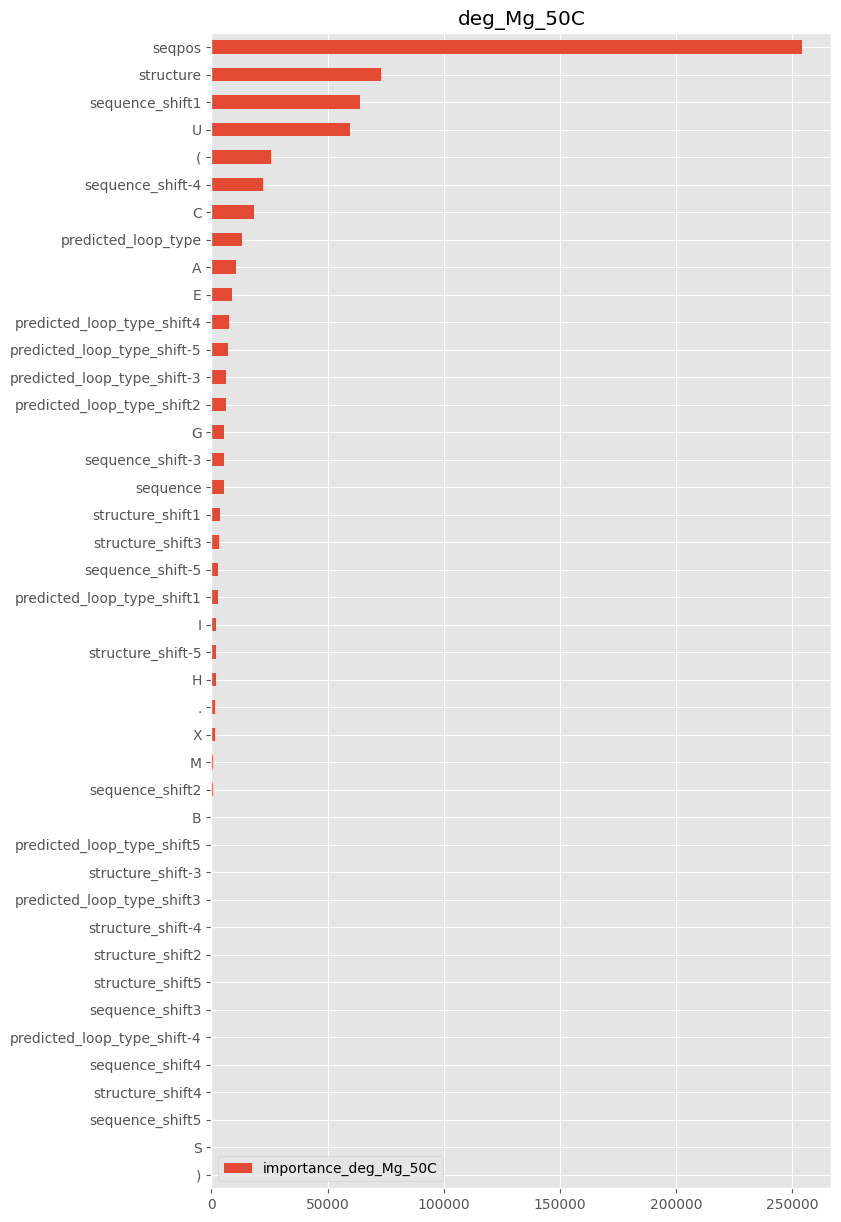

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 1.94885


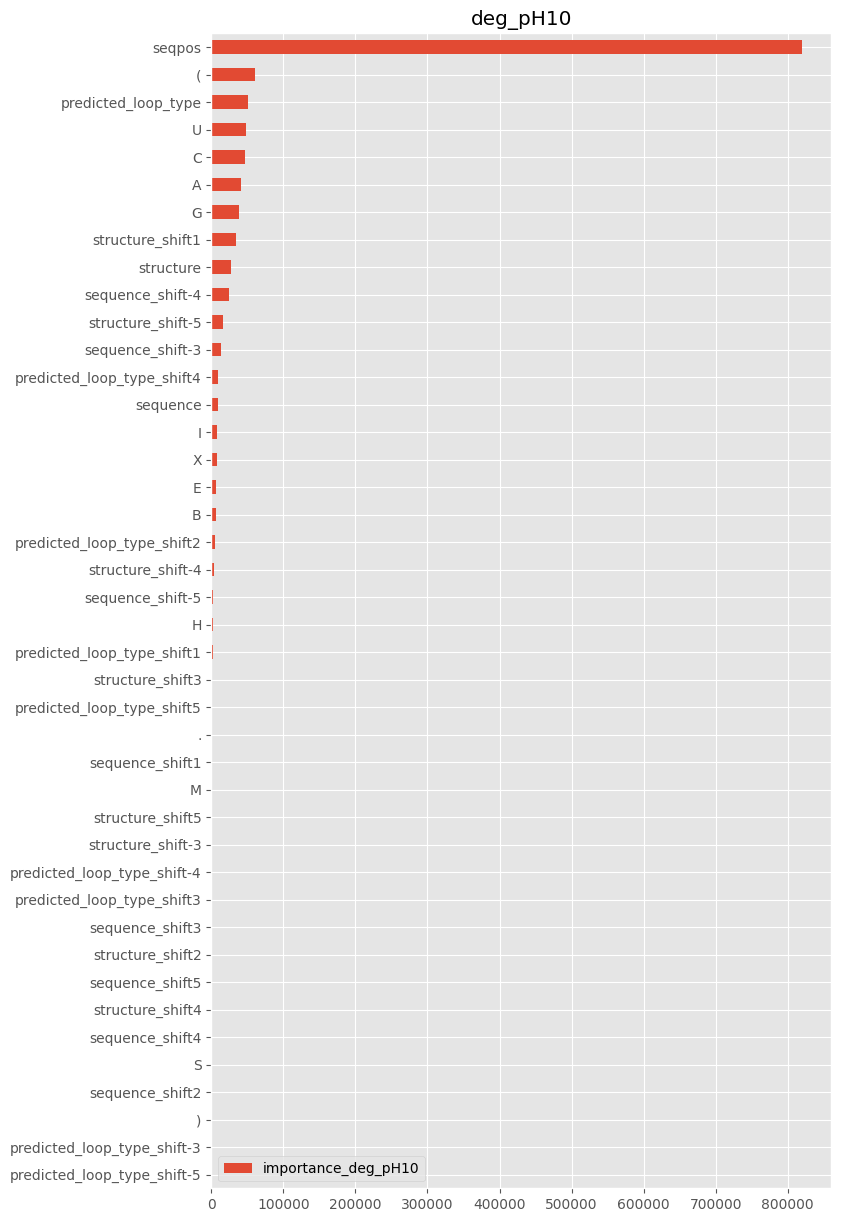

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 1.66443e+08


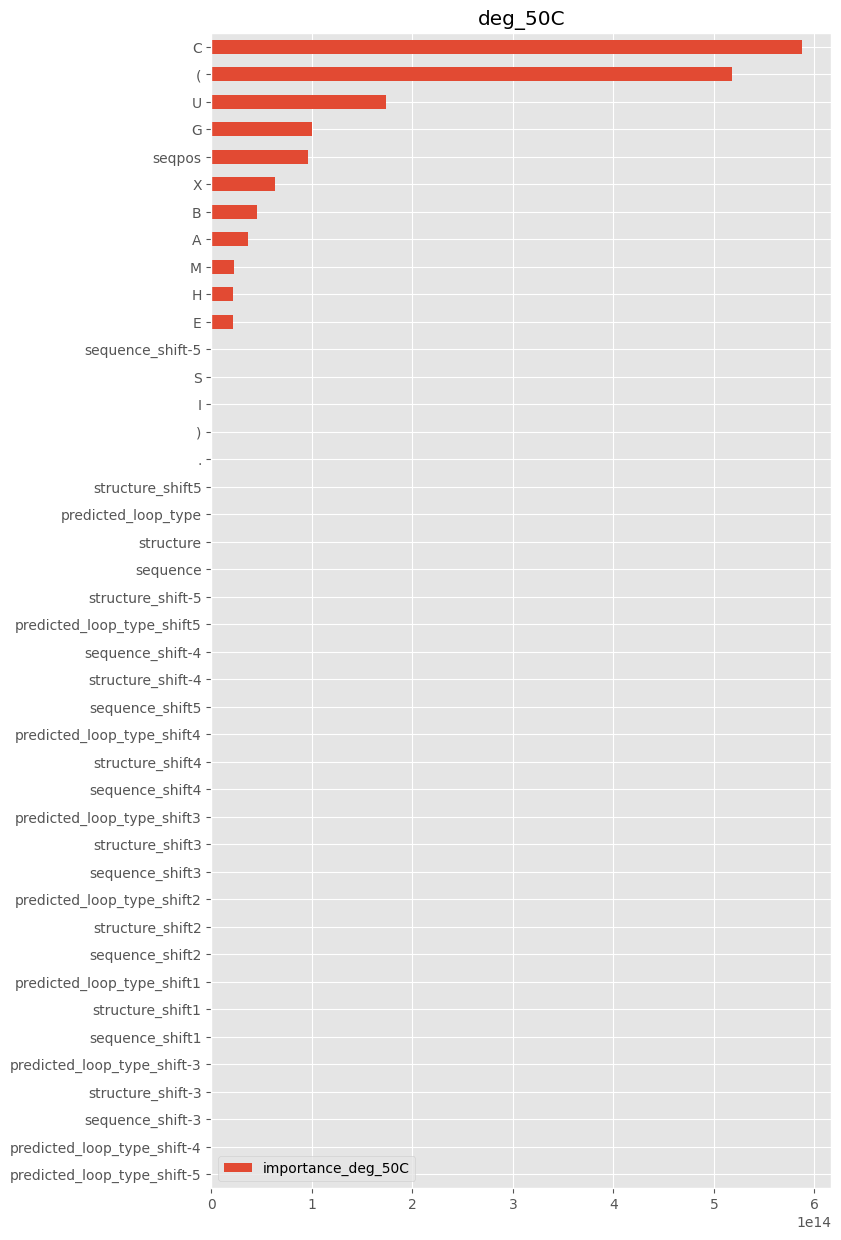

In [ ]:
fis = []
for t in TARGETS:
    #print(f'==== Running for target {t} ====')
    X_train = train_long.dropna(subset=[t]).loc[train_long['id'].isin(train_ids)][FEATURES].copy()
    y_train = train_long.dropna(subset=[t]).loc[train_long['id'].isin(train_ids)][t].copy()
    X_val = train_long.dropna(subset=[t]).loc[train_long['id'].isin(val_ids)][FEATURES].copy()
    y_val = train_long.dropna(subset=[t]).loc[train_long['id'].isin(val_ids)][t].copy()
    X_test = test_long[FEATURES].copy()
    y_train = pd.to_numeric(y_train)
    y_val = pd.to_numeric(y_val)
    
    reg = lgb.LGBMRegressor(n_estimators=100, #10000
                            learning_rate=0.01,
                            importance_type='gain')
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
           verbose=1000,
           early_stopping_rounds=100) # early_stopping_rounds=500

    fi_df = pd.DataFrame(index=FEATURES, 
                 data=reg.feature_importances_,
                 columns=[f'importance_{t}'])
    
    fi_df.sort_values(f'importance_{t}') \
        .plot(kind='barh', figsize=(8, 15), title=t)
    plt.show()
    fis.append(fi_df)
    
    test_long[f'{t}_pred'] = reg.predict(X_test)

In [ ]:
test_long['id_seqpos'] = test_long['id'] + '_' + test_long['seqpos'].astype('str')

test_long['deg_pH10'] = 0
test_long['deg_50C'] = 0
test_long = test_long.rename(columns={'reactivity_pred':'reactivity',
                          'deg_Mg_pH10_pred': 'deg_Mg_pH10',
                          'deg_Mg_50C_pred': 'deg_Mg_50C'})

ss = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')
assert test_long[ss.columns].shape == ss.shape

test_long[ss.columns].to_csv('submission.csv', index=False)

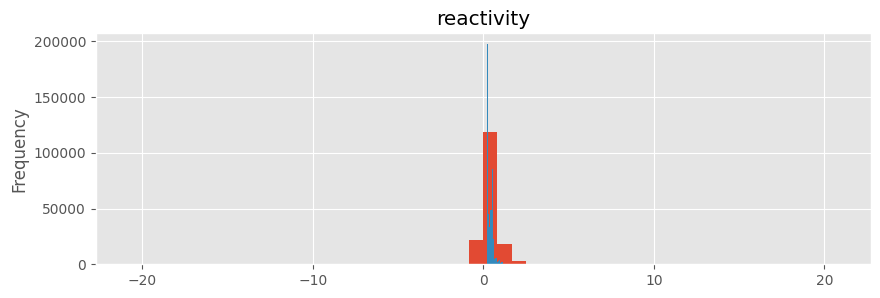

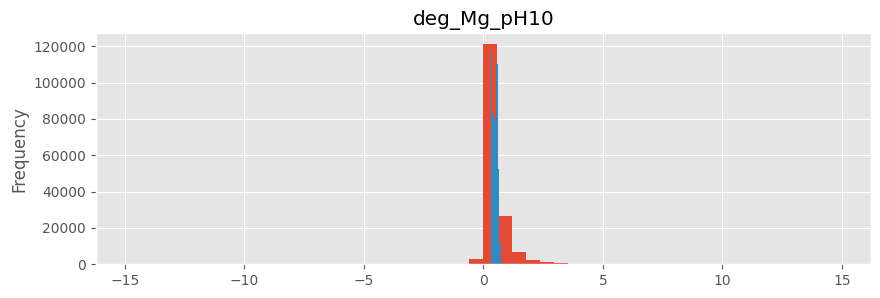

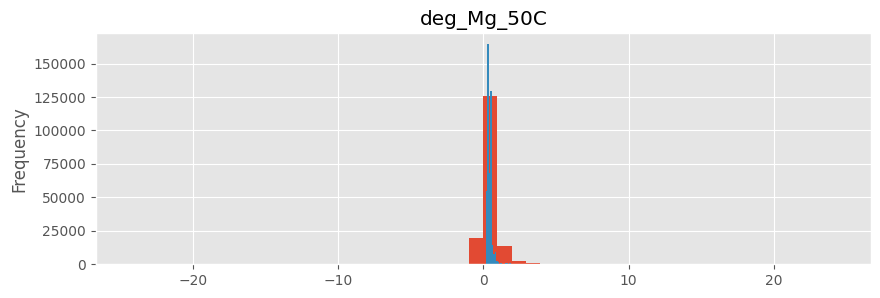

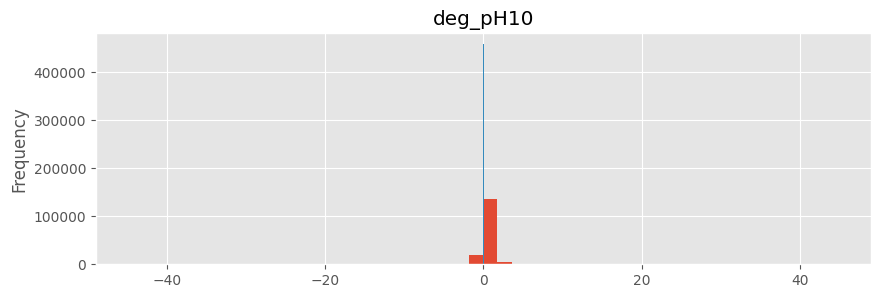

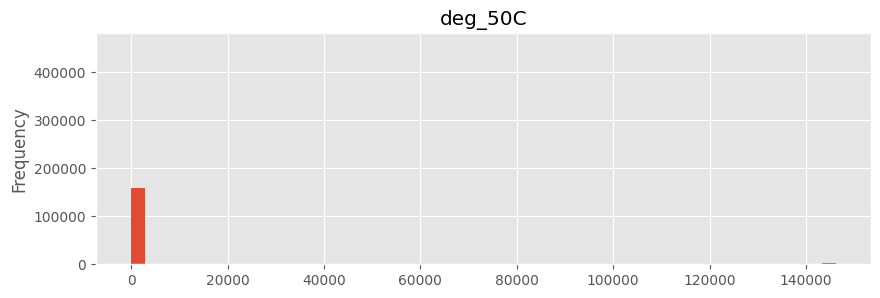

In [ ]:
for t in TARGETS:
    train_long[t].dropna().astype('float').plot(kind='hist', bins=50, figsize=(10, 3), title=t)
    test_long[t].plot(kind='hist', bins=50, figsize=(10, 3), title=t)
    plt.show()

**Section 3- Wavenet + GRU**

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 10.7MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import seaborn as sns
import math
import random
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

In [ ]:
# Basic training configurations
# Number of folds for KFold validation strategy
FOLDS = 2 
# Number of epochs to train each model
EPOCHS = 65
# Batch size
BATCH_SIZE = 64
# Learning rate
LR = 0.001
# Verbosity
VERBOSE = 2
# Seed for deterministic results
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Read training, test and sample submission data
train = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/train.json', \
                     lines=True) # Read the file as a json object per line
test = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/test.json', lines=True)
ss = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')


In [ ]:
# Target column list
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

# Dictionary comprehension to map the token with an specific id
token2int = {x: i for i, x in enumerate('().ACGUBEHIMSX')}

In [ ]:
# Preprocesing function to transform features to 3d format
def preprocess_inputs(df, cols = ['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]\
            .applymap(lambda seq: [token2int[x] for x in seq])\
            .values\
            .tolist()
        ),
        (0, 2, 1)
    )

In [ ]:
# Transform training feature sequences to a 3d matrix of (x, 107, 3)
train_inputs = preprocess_inputs(train)
# Transform training targets sequences to a 3d matrix of (x, 68, 5)
train_labels = np.array(train[target_cols].values.tolist()).transpose(0, 2, 1)
# Get different test sets
public_test_df = test[test['seq_length'] == 107]
private_test_df = test[test['seq_length'] == 130]
# Preprocess the test sets to the same format as our training data
public_test = preprocess_inputs(public_test_df)
private_test = preprocess_inputs(private_test_df)

In [ ]:
# Custom loss_function
def CMCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [ ]:
# Function to build our wave net model
def build_model(seq_len = 107, pred_len = 68, embed_dim = 85, dropout = 0.10):
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2 ** i for i in range(n)]
        x = tf.keras.layers.Conv1D(filters = filters, 
                                   kernel_size = 1,
                                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = tf.keras.layers.Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = tf.keras.layers.Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = tf.keras.layers.Multiply()([tanh_out, sigm_out])
            x = tf.keras.layers.Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = tf.keras.layers.Add()([res_x, x])
        return res_x
    
    inputs = tf.keras.layers.Input(shape = (seq_len, 3))
    embed = tf.keras.layers.Embedding(input_dim = len(token2int), output_dim = embed_dim)(inputs)
    reshaped = tf.reshape(embed, shape = (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
    reshaped = tf.keras.layers.SpatialDropout1D(dropout)(reshaped)
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, 
                                                          dropout = dropout, 
                                                          return_sequences = True, 
                                                          kernel_initializer = 'orthogonal'))(reshaped)
    x = wave_block(x, 16, 3, 12)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = wave_block(x, 32, 3, 8)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = wave_block(x, 64, 3, 4)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = wave_block(x, 128, 3, 1)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    
    truncated = x[:, :pred_len]
    out = tf.keras.layers.Dense(5, activation = 'linear')(truncated)
    model = tf.keras.models.Model(inputs = inputs, outputs = out)
    opt = tf.keras.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer = opt,
                  loss = tf.keras.losses.MeanSquaredLogarithmicError(),
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [ ]:
# Evaluation metric for this problem (mean columnwise root mean squared error)
def mcrmse(y_true, y_pred):
    y_true_ = y_true.reshape(163200, 5)
    y_pred_ = y_pred.reshape(163200, 5)
    y_true0 = y_true_[:, 0]
    y_true1 = y_true_[:, 1]
    y_true2 = y_true_[:, 2]
    y_true3 = y_true_[:, 3]
    y_true4 = y_true_[:, 4]
    y_pred0 = y_pred_[:, 0]
    y_pred1 = y_pred_[:, 1]
    y_pred2 = y_pred_[:, 2]
    y_pred3 = y_pred_[:, 3]
    y_pred4 = y_pred_[:, 4]
    rmse0 = math.sqrt(metrics.mean_squared_error(y_true0, y_pred0))
    rmse1 = math.sqrt(metrics.mean_squared_error(y_true1, y_pred1))
    rmse2 = math.sqrt(metrics.mean_squared_error(y_true2, y_pred2))
    rmse3 = math.sqrt(metrics.mean_squared_error(y_true3, y_pred3))
    rmse4 = math.sqrt(metrics.mean_squared_error(y_true4, y_pred4))
    return np.mean([rmse0, rmse1, rmse2, rmse3, rmse4])

In [ ]:
def train_and_evaluate(train_inputs, train_labels, public_test, private_test):
        
    oof_preds = np.zeros((train_inputs.shape[0], 68, 5))
    public_preds = np.zeros((public_test.shape[0], 107, 5))
    private_preds = np.zeros((private_test.shape[0], 130, 5))

    kfold = KFold(FOLDS, shuffle = True, random_state = SEED)
    for fold, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
        
        print(f'Training fold {fold + 1}')
    
        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'fold_{fold + 1}.h5', 
                                                        monitor = 'val_loss',
                                                        save_best_only = True,
                                                        save_weights_only = True
                                                       )
        # Using learning rate scheduler
        cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                              mode = 'min', 
                                                              factor = 0.5, 
                                                              patience = 5, 
                                                              verbose = 1, 
                                                              min_delta = 0.00001
                                                             )
    
        x_train, x_val = train_inputs[train_index], train_inputs[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        K.clear_session()
        # Build a truncated model based on train target lengths
        model = build_model()
        history = model.fit(x_train, y_train,
                            validation_data = (x_val, y_val),
                            batch_size = BATCH_SIZE,
                            epochs = EPOCHS,
                            callbacks = [checkpoint, cb_lr_schedule],
                            verbose = VERBOSE)
    
        # Load best model to predict the validation set
        model.load_weights(f'fold_{fold + 1}.h5')
        oof_preds[val_index] = model.predict(x_val)

        # Load best model and predict the entire test sequence for the public test
        short = build_model(seq_len = 107, pred_len = 107)
        short.load_weights(f'fold_{fold + 1}.h5')
        public_preds += short.predict(public_test) / FOLDS

        # Load best model and predict the entire test sequence for the private test
        long = build_model(seq_len = 130, pred_len = 130)
        long.load_weights(f'fold_{fold + 1}.h5')
        private_preds += long.predict(private_test) / FOLDS
        
        print('-'*50)
        print('\n')
    
    # Calculate out of folds predictions
    mean_col_rmse = mcrmse(train_labels, oof_preds)

    print(f'Our out of folds mean columnwise root mean squared error is {mean_col_rmse}')
    
    return public_preds, private_preds

In [ ]:
public_preds, private_preds = train_and_evaluate(
        train_inputs, train_labels, public_test, private_test)

Training fold 1
Epoch 1/65
19/19 - 89s - loss: 0.1390 - root_mean_squared_error: 1.3320 - val_loss: 0.1740 - val_root_mean_squared_error: 1.1506
Epoch 2/65
19/19 - 9s - loss: 0.0940 - root_mean_squared_error: 1.1820 - val_loss: 0.1657 - val_root_mean_squared_error: 1.1686
Epoch 3/65
19/19 - 9s - loss: 0.0759 - root_mean_squared_error: 1.0288 - val_loss: 0.1548 - val_root_mean_squared_error: 1.1348
Epoch 4/65
19/19 - 8s - loss: 0.0646 - root_mean_squared_error: 0.9313 - val_loss: 0.1318 - val_root_mean_squared_error: 1.0712
Epoch 5/65
19/19 - 8s - loss: 0.0585 - root_mean_squared_error: 0.8920 - val_loss: 0.1145 - val_root_mean_squared_error: 1.0423
Epoch 6/65
19/19 - 8s - loss: 0.0548 - root_mean_squared_error: 0.8781 - val_loss: 0.1067 - val_root_mean_squared_error: 1.0199
Epoch 7/65
19/19 - 9s - loss: 0.0531 - root_mean_squared_error: 0.8718 - val_loss: 0.0756 - val_root_mean_squared_error: 0.9770
Epoch 8/65
19/19 - 9s - loss: 0.0517 - root_mean_squared_error: 0.8690 - val_loss: 0.06

In [ ]:

# Function to get our predictions in the correct format
def inference_format(public_test_df, public_preds, private_test_df, private_preds, target_cols):
    predictions = []
    for test, preds in [(public_test_df, public_preds), (private_test_df, private_preds)]:
        for index, uid in enumerate(test['id']):
            single_pred = preds[index]
            single_df = pd.DataFrame(single_pred, columns = target_cols)
            # Add id
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            predictions.append(single_df)
            
    predictions = pd.concat(predictions)
    return predictions


# Get our predictions in the correct format
predictions = inference_format(public_test_df, public_preds, 
                               private_test_df, private_preds, target_cols)
# Sanity check
#submission = sample_sub[['id_seqpos']].merge(predictions, on = ['id_seqpos'])
submission = ss[['id_seqpos']].merge(predictions, on = ['id_seqpos'])

submission.to_csv('submission.csv', index = False)
print('Submission saved')
submission.head()

Submission saved


id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0  id_00073f8be_0    0.743580     0.642065  2.054834    0.546357  0.736277
1  id_00073f8be_1    2.247940     3.323577  4.278809    3.255697  2.751048
2  id_00073f8be_2    1.371200     0.505385  0.695875    0.637965  0.722545
3  id_00073f8be_3    1.420652     1.170944  1.289771    1.633432  1.559224
4  id_00073f8be_4    0.842604     0.585723  0.582043    0.809269  0.771480

**Section 4- GRU + LSTM**

We will be predicting the degradation rates at various locations along RNA sequence.

The raw dataset (which can be found on the Kaggle competition) consists of 2400 mRNA samples. Each mRNA consists of 107 nucleotides and various measurments were performed on the first 68 nucleotides. This consisted of reactivity, degradation at pH10 with and without magnesium, and degradation at 50 degrees centigrade, with and without magnesium.

In [ ]:
!pip install tensorflow-addons

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, seaborn as sns
import math, json, os, random
from matplotlib import pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import KMeans

In [ ]:
def seed_everything(seed = 34):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

In [ ]:
train = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/train.json', \
                     lines=True) # Read the file as a json object per line
test = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('/content/drive/MyDrive/MRNA-vaccine/sample_submission.csv')

In [ ]:
print(train.columns)

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')


In [ ]:
# Check if any missing values are present in training set
print(train.shape)
if ~train.isnull().any().any(): print('No missing values')
train.head()

(2400, 19)
No missing values


index            id                                           sequence  \
0      0  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1      1  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
2      2  id_006f36f57  GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...   
3      3  id_0082d463b  GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...   
4      4  id_0087940f4  GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...   

                                           structure  \
0  .....((((((.......)))).)).((.....((..((((((......   
1  .....(((((((((((((((((((((((....)))))))))).)))...   
2  .....((((.((.....((((.(((.....)))..((((......)...   
3  ......((((((((((((((((......))))))))))))))))((...   
4  .....(((((((.((((((((((((.(((((((((....)))))))...   

                                 predicted_loop_type  signal_to_noise  \
0  EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...            6.894   
1  EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...            0.193   
2  EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...            8.800   
3  EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...            0.104   
4  EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...            0.423   

   SN_filter  seq_length  seq_scored  \
0          1         107          68   
1          0         107          68   
2          1         107          68   
3          0         107          68   
4          0         107          68   

                                    reactivity_error  \
0  [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...   
1  [2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...   
2  [0.0931, 0.13290000000000002, 0.11280000000000...   
3  [3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...   
4  [1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...   

                                   deg_error_Mg_pH10  \
0  [0.26130000000000003, 0.38420000000000004, 0.1...   
1  [73705.3985, 73705.3985, 73705.3985, 73705.398...   
2  [0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...   
3  [73705.3985, 73705.3985, 73705.3985, 73705.398...   
4  [4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...   

                                      deg_error_pH10  \
0  [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...   
1  [10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...   
2  [0.17020000000000002, 0.178, 0.111, 0.091, 0.0...   
3  [11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...   
4  [3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...   

                                    deg_error_Mg_50C  \
0  [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...   
1  [16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...   
2  [0.1033, 0.1464, 0.1126, 0.09620000000000001, ...   
3  [121286.7181, 121286.7182, 121286.7181, 121286...   
4  [2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...   

                                       deg_error_50C  \
0  [0.2167, 0.34750000000000003, 0.188, 0.2124, 0...   
1  [15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...   
2  [0.14980000000000002, 0.1761, 0.1517, 0.116700...   
3  [15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...   
4  [1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...   

                                          reactivity  \
0  [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...   
1  [0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....   
2  [0.44820000000000004, 1.4822, 1.1819, 0.743400...   
3  [0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
4  [0.8267, 2.6577, 2.8481, 0.40090000000000003, ...   

                                         deg_Mg_pH10  \
0  [0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.2504, 1.4021, 0.9804, 0.49670000000000003, ...   
3  [0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
4  [2.1058, 3.138, 2.5437000000000003, 1.0932, 0....   

                                            deg_pH10  \
0  [2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...   
1  [4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [ ]:
# Check if any missing values are present in test set
print(test.shape)
if ~test.isnull().any().any(): print('No missing values')
test.head()

(3634, 7)
No missing values


index            id                                           sequence  \
0      0  id_00073f8be  GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...   
1      1  id_000ae4237  GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...   
2      2  id_00131c573  GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...   
3      3  id_00181fd34  GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...   
4      4  id_0020473f7  GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...   

                                           structure  \
0  ......((((((((((.(((((.....))))))))((((((((......   
1  .....((((..((((((...(((((.....((((....)))).......   
2  ...........((.(((.(.(..((..((..((((...))))..))...   
3  ......((((((((((....))))))))))((((((..((.(((.....   
4  .....(((((((((((((((((((((((((((((((((((((((((...   

                                 predicted_loop_type  seq_length  seq_scored  
0  EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...         107          68  
1  EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...         130          91  
2  EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...         107          68  
3  EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...         107          68  
4  EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...         130          91

In [ ]:
# Check if any missing values are present in sample submission set
print(sample_sub.shape)
if ~sample_sub.isnull().any().any(): print('No missing values')
sample_sub.head()

(457953, 6)
No missing values


id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  deg_50C
0  id_00073f8be_0         0.0          0.0       0.0         0.0      0.0
1  id_00073f8be_1         0.0          0.0       0.0         0.0      0.0
2  id_00073f8be_2         0.0          0.0       0.0         0.0      0.0
3  id_00073f8be_3         0.0          0.0       0.0         0.0      0.0
4  id_00073f8be_4         0.0          0.0       0.0         0.0      0.0

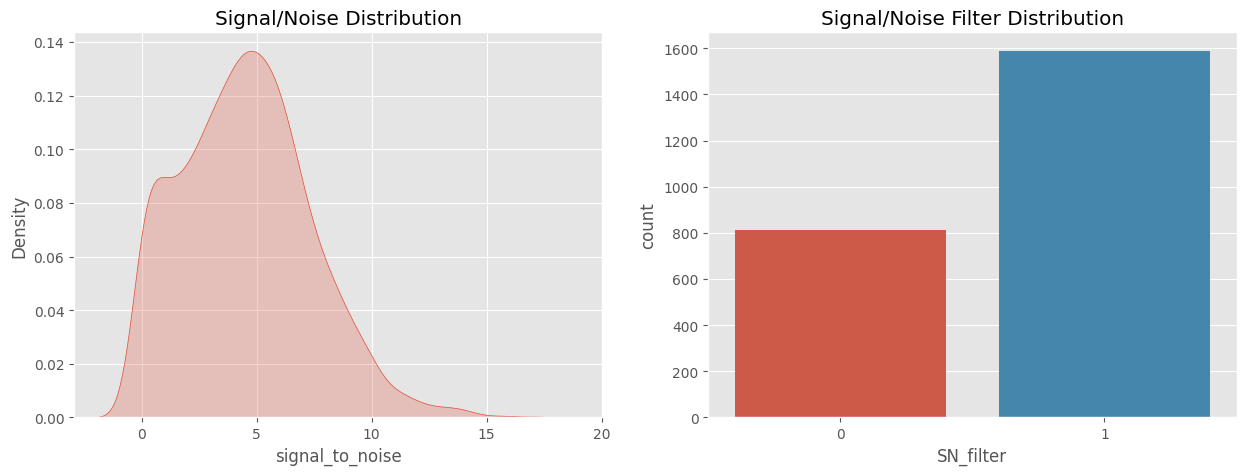

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(train['signal_to_noise'], shade=True, ax=ax[0])
sns.countplot(train['SN_filter'], ax=ax[1])

ax[0].set_title('Signal/Noise Distribution')
ax[1].set_title('Signal/Noise Filter Distribution');

Here we can see that the data we have is the sequence and the predicted structure and loop type of each base in the RNA. The feature `reactivity` measures the degradation at each base. The higher the `reactivity` the more likely the RNA is to degrade at that base.

In [ ]:
train.head(1).T

0
index                                                                0
id                                                        id_001f94081
sequence             GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure            .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type  EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                  6.894
SN_filter                                                            1
seq_length                                                         107
seq_scored                                                          68
reactivity_error     [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10    [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10       [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C     [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C        [0.2167, 0.34750000000000003, 0.188, 0.2124, 0...
reactivity           [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...
deg_Mg_pH10          [0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...
deg_pH10             [2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...
deg_Mg_50C           [0.35810000000000003, 2.9683, 0.2589, 1.4552, ...
deg_50C              [0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...

The `SN_filter` is the signal-to-noise filter capturing which RNA molecules passed the evaluation criteria defined by the Standford researchers. This means we will drop the rows with `SN_filter = 0`.

There are some RNAs that have quite a large amount of noise which is filtered by the `SN_filter`.

In [ ]:
print("Samples (signal_to_noise > 1): ", len(train.loc[(train['signal_to_noise'] > 1)]))
print("Samples (SN_filter = 1): ", len(train.loc[(train['SN_filter'] == 1)]))
print("Samples (signal_to_noise > 1, but SN_filter == 0): ", \
      len(train.loc[(train['signal_to_noise'] > 1) & (train['SN_filter'] == 0)]))

Samples (signal_to_noise > 1):  2096
Samples (SN_filter = 1):  1589
Samples (signal_to_noise > 1, but SN_filter == 0):  509


The `bpps` are numpy arrays we pre-calculated for each sequence. They're matrices of base pair probabilities. Biophysically speaking, this matrix gives the probability that each pair of nucleotides in the RNA forms a base pair (given a particular model of RNA folding). 

So, we have this readily available N into N matrix. This is used to determine the likely structures of mRNA. bpps is base probability matrix, a matrix of the probability of each base dating with every other base in the mRNA. 

So, assuming the mRNA molecule consists of 10 characters: ACAUUGGGAU. Then the bpps is a 10 x 10 matrix. Take the first base 'A'. So we have the probability of the first base 'A' pairing up with the remaining 9 bases. I guess A pairing with itself is 0 and the sum of the probabilities of the remaining 9 bpp will be the total probability of A being paired. So P(the probability of 'i' th base in the sequence seq being paired) = sum of probabilities of P(i,j) being paired) from j=0 to len(seq)-1.

In [ ]:
bpps_files = os.listdir('/content/drive/MyDrive/bpps1/')
example_bpps = np.load(f'/content/drive/MyDrive/bpps1/{bpps_files[0]}')

In [ ]:
# sum value of bpps
def generate_bpps_sum(dataframe):
    bpps_arr = []
    for molecule_id in dataframe['id'].values.tolist():
        bpps_arr.append(np.load(f"/content/drive/MyDrive/bpps1/{molecule_id}.npy").sum(axis=1))
    return bpps_arr

# Generate row-wise max value in Numpy matrix from 'bpps' folder against each molecule id.
def generate_bpps_max(dataframe):
    bpps_arr = []
    for molecule_id in dataframe['id'].values.tolist():
        bpps_arr.append(np.load(f"/content/drive/MyDrive/bpps1/{molecule_id}.npy").max(axis=1))
    return bpps_arr

# Non-0 number of 'bpps'
def generate_bpps_nb(dataframe):
    #bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
    #bpps_nb_std = 0.08914 # std of bpps_nb across all training data
    bpps_arr = []
    for molecule_id in dataframe['id'].values.tolist():
        # Load 'bpps' data against a specific molecule id
        bpps = np.load(f"/content/drive/MyDrive/bpps1/{molecule_id}.npy")
        # bpps.shape[0]: 107 or 130
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        #bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 

# Randomly select 200 samples from both train & test sets
train = train.sample(200, random_state=10, replace=True)
test = test.sample(200, random_state=10, replace=True)

train['bpps_sum'] = generate_bpps_sum(train)
test['bpps_sum'] = generate_bpps_sum(test)

train['bpps_max'] = generate_bpps_max(train)
test['bpps_max'] = generate_bpps_max(test)

train['bpps_nb'] = generate_bpps_nb(train)
test['bpps_nb'] = generate_bpps_nb(test)

train.head(1).T
#print(train.bpps_sum.count)

2042
index                                                             2042
id                                                        id_dab0058d0
sequence             GGAAAAGGAUCCCUAUGGAGCUGGGAUCUAGACCGAGAGGUCUAGA...
structure            ......((((((((((((((((((((((((((((....))))))))...
predicted_loop_type  EEEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSS...
signal_to_noise                                                      0
SN_filter                                                            0
seq_length                                                         107
seq_scored                                                          68
reactivity_error     [146151.225, 146151.225, 146151.225, 103344.53...
deg_error_Mg_pH10    [104235.1742, 104235.1742, 104235.1742, 104235...
deg_error_pH10       [314833.5695, 314833.5695, 314833.5695, 314833...
deg_error_Mg_50C     [121286.7183, 121286.7183, 121286.7183, 121286...
deg_error_50C        [271158.604, 271158.604, 271158.604, 271158.60...
reactivity           [0.0, 0.0, 0.0, 20.6648, 0.0, 0.0, 0.0, 0.0, 0...
deg_Mg_pH10          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
deg_pH10             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
deg_Mg_50C           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
deg_50C              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
bpps_sum             [0.01918430598994291, 0.005392688742720808, 3....
bpps_max             [0.00485165840189941, 0.001328964983520784, 3....
bpps_nb              [0.06542056074766354, 0.06542056074766354, 0.0...

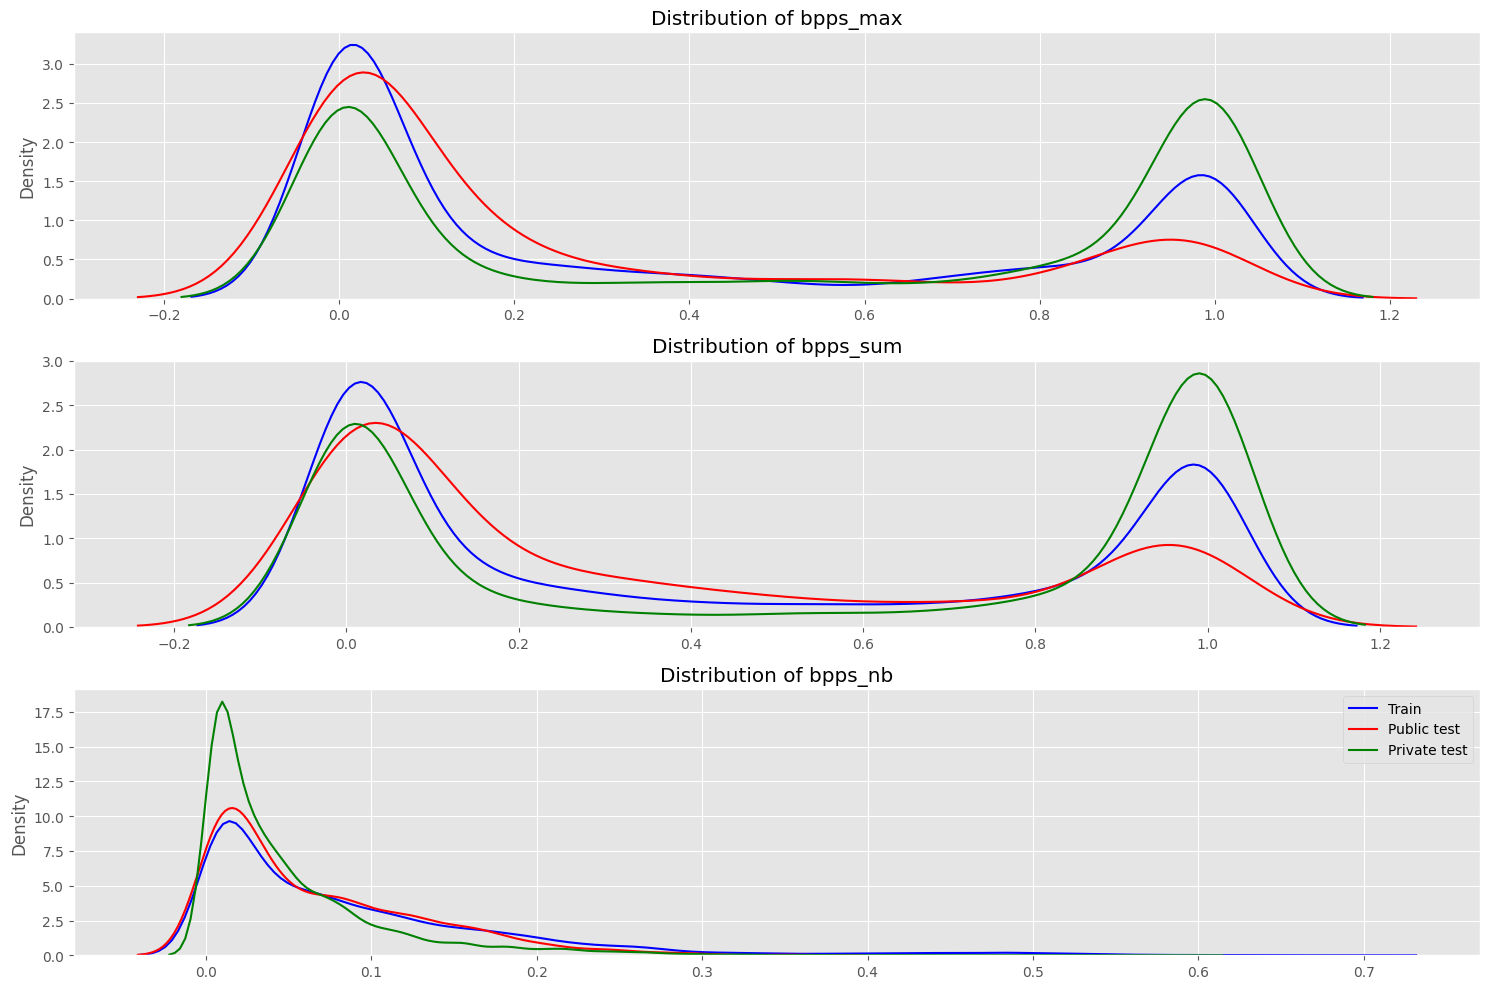

In [ ]:
fig, ax = plt.subplots(3, figsize=(15, 10))

# KDE plot for training, public test (seq. length 107) 
# and private test (seq. length 130)
sns.kdeplot(np.array(train['bpps_max'].to_list()).reshape(-1),
            color="Blue", ax=ax[0], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_max'].to_list()).reshape(-1),
            color="Red", ax=ax[0], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_max'].to_list()).reshape(-1),
            color="Green", ax=ax[0], label='Private test')

# KDE plot for bpps_sum column in training, public test (seq. length 107) 
# and private test (seq. length 130)
sns.kdeplot(np.array(train['bpps_sum'].to_list()).reshape(-1),
            color="Blue", ax=ax[1], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_sum'].to_list()).reshape(-1),
            color="Red", ax=ax[1], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_sum'].to_list()).reshape(-1),
            color="Green", ax=ax[1], label='Private test')

sns.kdeplot(np.array(train['bpps_nb'].to_list()).reshape(-1),
            color="Blue", ax=ax[2], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_nb'].to_list()).reshape(-1),
            color="Red", ax=ax[2], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_nb'].to_list()).reshape(-1),
            color="Green", ax=ax[2], label='Private test')

ax[0].set_title('Distribution of bpps_max')
ax[1].set_title('Distribution of bpps_sum')
ax[2].set_title('Distribution of bpps_nb')

plt.legend()
plt.tight_layout();

In [ ]:
DENOISE = False

In [ ]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [ ]:
token2int = {val:idx for idx, val in enumerate('().ACGUBEHIMSX')}
print(token2int)
len(token2int)

{'(': 0, ')': 1, '.': 2, 'A': 3, 'C': 4, 'G': 5, 'U': 6, 'B': 7, 'E': 8, 'H': 9, 'I': 10, 'M': 11, 'S': 12, 'X': 13}


14

In [ ]:
def preprocess_inputs(df, columns=['sequence', 'structure', 'predicted_loop_type']):
    arr = np.array(
            df[columns]
            .applymap(lambda sequence: [token2int[idx] for idx in sequence])
            .values
            .tolist()
          )
    base_features = np.transpose(a=arr, axes=(0, 2, 1))
    """
    base_fea = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    
    bpps_sum_features = np.array(df['bpps_sum'].to_list())[:, :, np.newaxis]
    bpps_max_features = np.array(df['bpps_max'].to_list())[:, :, np.newaxis]

    mylist = [np.transpose(a=arr, axes=(0, 2, 1)), 
              np.array(df['bpps_sum'].to_list())[:, :, np.newaxis], 
              np.array(df['bpps_max'].to_list())[:, :, np.newaxis]]
    """
    # numpy.newaxis is used to increase the dimension of the existing array by one more dimension, when used once.
    mylist = [base_features, 
              np.array(df['bpps_sum'].to_list())[:, :, np.newaxis], 
              np.array(df['bpps_max'].to_list())[:, :, np.newaxis]]
    print('mylist = ', mylist)
    
    return np.concatenate(mylist, 2)
    #return np.concatenate([base_features, bpps_sum_features, bpps_max_features], 2)

In [ ]:
if DENOISE:
    train = train[train['signal_to_noise'] > .25]

In [ ]:
def rmse(y_actual, y_predicted):
    mse = tf.keras.losses.mean_squared_error(y_true=y_actual, y_pred=y_predicted)
    return K.sqrt(mse)

# Mean column−wise root mean squared
def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

In [ ]:
# GRU: Gated Recurrent Unit
# Based on available runtime hardware and constraints, this layer will 
# choose different implementations (cuDNN-based or pure-TensorFlow) to 
# maximize the performance.

"""
NVIDIA CUDA Deep Neural Network (cuDNN) is a GPU-accelerated library of 
primitives for deep neural networks. 
It provides highly tuned implementations of routines arising frequently 
in DNN applications.
"""
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                layer=tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

"""
Long short-term memory (LSTM) is an artificial Recurrent Neural Network (RNN) 
architecture used in the field of deep learning. 
LSTM networks are well-suited to classifying, processing and making 
predictions based on time series data, since there can be lags of unknown 
duration between important events in a time series.
"""
def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                layer=tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def build_model(rnn='gru', convolve=False, conv_dim=512, 
                dropout=.4, sp_dropout=.2, embed_dim=200,
                hidden_dim=256, layers=3,
                seq_len=107, pred_len=68):
    
# Inputs
    inputs = tf.keras.layers.Input(shape=(seq_len, 5))
    """categorical_feats = inputs[:, :, :3]
    embed = tf.keras.layers.Embedding(input_dim=len(token2int),
                                      output_dim=embed_dim)(categorical_feats)"""
    """
    Keras offers an Embedding layer that can be used for neural networks 
    on text data. It requires that the input data be integer encoded, so that 
    each word is represented by a unique integer. ... It can be used to load 
    a pre-trained word embedding model, a type of transfer learning.
    """
    embedding = tf.keras.layers.Embedding(input_dim=len(token2int),
                                      output_dim=embed_dim)(inputs[:, :, :3])

    reshaped = tf.reshape(
        tensor=embedding, shape=(-1, embedding.shape[1],  embedding.shape[2] * embedding.shape[3]))
    
    # Reshapes a tensor.
    reshaped = tf.keras.layers.concatenate([reshaped, inputs[:, :, 3:]], axis=2)

    """numerical_feats = inputs[:, :, 3:]
    reshaped = tf.keras.layers.concatenate([reshaped, numerical_feats], axis=2)"""
    hidden = tf.keras.layers.SpatialDropout1D(sp_dropout)(reshaped)
    
    if convolve == True:
        hidden = tf.keras.layers.Conv1D(
            filters=conv_dim, 
            kernel_size=5, 
            padding='same', 
            activation=tf.keras.activations.swish)(hidden)

# RNN Layers
    if rnn is 'gru':
        for _ in range(layers):
            hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif rnn is 'lstm':
        for _ in range(layers):
            hidden = lstm_layer(hidden_dim, dropout)(hidden)

# Output
    out = hidden[:, :pred_len]
    outputs = tf.keras.layers.Dense(units=5, activation='linear')(out)
    #print('outputs=', outputs)
    
    # Model groups layers into an object with training and inference features.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    adam = tf.optimizers.Adam()
    model.compile(optimizer=adam, loss=mcrmse)

    return model

In [ ]:
test_model = build_model(rnn='gru')
test_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 107, 5)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 107, 3)       0           input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 107, 3, 200)  2800        tf.__operators__.getitem_3[0][0] 
__________________________________________________________________________________________________
tf.reshape_3 (TFOpLambda)       (None, 107, 600)     0           embedding_3[0][0]                
____________________________________________________________________________________________

In [ ]:
#def train_and_infer(rnn, STRATIFY=True, FOLDS=4, EPOCHS=50, BATCH_SIZE=64,
#                    REPEATS=3, SEED=34, VERBOSE=2):
def train_and_infer(rnn, STRATIFY=True, FOLDS=2, EPOCHS=50, BATCH_SIZE=64,
                    REPEATS=2, SEED=34, VERBOSE=2):

    #get test now for OOF 
    public_df = test.query("seq_length == 107").copy()
    private_df = test.query("seq_length == 130").copy()
    private_preds = np.zeros((private_df.shape[0], 130, 5))
    #print('private_preds=', private_preds)
    
    public_preds = np.zeros((public_df.shape[0], 107, 5))
    public_inputs = preprocess_inputs(public_df)
    private_inputs = preprocess_inputs(private_df)

    #Evaluate Test Time Augmentation (TTA) effects/post processing
    """
    Test-time augmentation, or TTA for short, is an application of data 
    augmentation to the test dataset. Specifically, it involves creating 
    multiple augmented copies of each image in the test set, having the 
    model make a prediction for each, then returning an ensemble of those predictions.
    """
    holdouts = []
    holdout_preds = []
    
    #to view learning curves
    histories = []
    
    #put similar RNA in the same fold
    gkf = GroupKFold(n_splits=FOLDS) # K-fold iterator variant with non-overlapping groups.
    kf = KFold(n_splits=FOLDS, random_state=SEED)
    kmeans_model = KMeans(n_clusters=200, random_state=SEED).fit(preprocess_inputs(train)[:,:,0])
    train['cluster_id'] = kmeans_model.labels_  # Labels of each point

    for _ in range(REPEATS):
        
        """for f, (train_index, val_index) in enumerate((gkf if STRATIFY else kf).split(train,
                train['reactivity'], train['cluster_id'] if STRATIFY else None)):"""
        if STRATIFY == True:
          mymodel = gkf
        else:
          mymodel = kf
          
        for f, (train_index, val_index) in enumerate(mymodel.split(train,
                train['reactivity'], train['cluster_id'] if STRATIFY else None)):
            #print('Here ... f=', f)
            #define training callbacks

            # Reduce learning rate when a metric has stopped improving.
            lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3, #patience=8
                                                               factor=.1,
                                                               #min_lr=1e-5,
                                                               verbose=VERBOSE)
            save = tf.keras.callbacks.ModelCheckpoint(f'model-{f}.h5')

            #define sample weight function

            epsilon = .1
            # Return the natural logarithm of one plus the input array, element-wise.
            # log1p is reverse of exp(x) – 1.
            sample_weighting = np.log1p(train.iloc[train_index]['signal_to_noise'] + epsilon) / 2

            #get train data
            trn = train.iloc[train_index]
            trn_ = preprocess_inputs(trn)
            trn_labs = np.array(trn[target_cols].values.tolist()).transpose((0, 2, 1))

            #get validation data
            val = train.iloc[val_index]
            val_all = preprocess_inputs(val)
            val = val[val.SN_filter == 1]
            val_ = preprocess_inputs(val)
            val_labs = np.array(val[target_cols].values.tolist()).transpose((0, 2, 1))

            #pre-build models for different sequence lengths
            model = build_model(rnn=rnn)
            model_short = build_model(rnn=rnn,seq_len=107, pred_len=107)
            model_long = build_model(rnn=rnn,seq_len=130, pred_len=130)

            #train model
            history = model.fit(
                trn_, trn_labs,
                validation_data = (val_, val_labs),
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                sample_weight=sample_weighting,
                callbacks=[save, lr_callback],
                verbose=VERBOSE
            )

            histories.append(history)

            #load best models
            model.load_weights(f'model-{f}.h5')
            model_short.load_weights(f'model-{f}.h5')
            model_long.load_weights(f'model-{f}.h5')

            holdouts.append(train.iloc[val_index])
            holdout_preds.append(model.predict(val_all))

            public_preds += model_short.predict(public_inputs) / (FOLDS * REPEATS)
            private_preds += model_long.predict(private_inputs) / (FOLDS * REPEATS)
        
        del model, model_short, model_long
        
    return holdouts, holdout_preds, public_df, public_preds, private_df, private_preds, histories

In [ ]:
gru_holdouts, gru_holdout_preds, public_df, gru_public_preds, \
      private_df, gru_private_preds, gru_histories = train_and_infer(rnn='gru')

mylist =  [array([[[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       ...,

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]]]), array([[[0.13492483],
        [0.15471476],
        [0.07051124],
        ...,
        [0.01349459],
        [0.01862272],
        [0.03164234]],

       [[0.07614303],
        [0.03135228],
        [0

In [ ]:
lstm_holdouts, lstm_holdout_preds, public_df, lstm_public_preds, \
    private_df, lstm_private_preds, lstm_histories = train_and_infer(rnn='lstm')

mylist =  [array([[[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       ...,

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]]]), array([[[0.13492483],
        [0.15471476],
        [0.07051124],
        ...,
        [0.01349459],
        [0.01862272],
        [0.03164234]],

       [[0.07614303],
        [0.03135228],
        [0

In [ ]:
def plot_learning_curves(results):

    fig, ax = plt.subplots(nrows=1, ncols=len(results['histories']), figsize = (20, 10))
    
    for i, result in enumerate(results['histories']):
        for history in result:
            ax[i].plot(history.history['loss'], color='C0')
            ax[i].plot(history.history['val_loss'], color='C1')
            ax[i].set_title(f"{results['models'][i]}")
            ax[i].set_ylabel('MCRMSE')
            ax[i].set_xlabel('Epoch')
            ax[i].legend(['train', 'validation'], loc = 'upper right')
            
results = {
            "models" : ['GRU', 'LSTM'],    
            "histories" : [gru_histories, lstm_histories],
            }

In [ ]:
AUGMENT = False

In [ ]:
def format_predictions(test_df, test_preds, val=False):
    preds = []
    
    for df, preds_ in zip(test_df, test_preds):
        for i, uid in enumerate(df['id']):
            single_pred = preds_[i]

            single_df = pd.DataFrame(single_pred, columns=target_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            if val: single_df['SN_filter'] = df[df['id'] == uid].SN_filter.values[0]

            preds.append(single_df)
    return pd.concat(preds).groupby('id_seqpos').mean().reset_index() if AUGMENT else pd.concat(preds)

In [ ]:
def get_error(preds):
    val = pd.read_json('/content/drive/MyDrive/MRNA-vaccine/train.json', lines=True)

    val_data = []
    for molecule_id in val['id'].unique():
        sample_data = val.loc[val['id'] == molecule_id]
        sample_seq_length = sample_data.seq_length.values[0]
        for i in range(68):
            sample_dict = {
                           'id_seqpos': sample_data['id'].values[0] + '_' + str(i),
                           'reactivity_gt': sample_data['reactivity'].values[0][i],
                           'deg_Mg_pH10_gt': sample_data['deg_Mg_pH10'].values[0][i],
                           'deg_Mg_50C_gt': sample_data['deg_Mg_50C'].values[0][i],
                           }
            
            val_data.append(sample_dict)
            
    val_data = pd.DataFrame(val_data)
    val_data = val_data.merge(preds, on='id_seqpos')

    rmses = []
    mses = []
    
    for col in ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']:
        rmse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean() ** .5
        mse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean()
        rmses.append(rmse)
        mses.append(mse)
        print(col, rmse, mse)

    print(np.mean(rmses), np.mean(mses))
    print('')

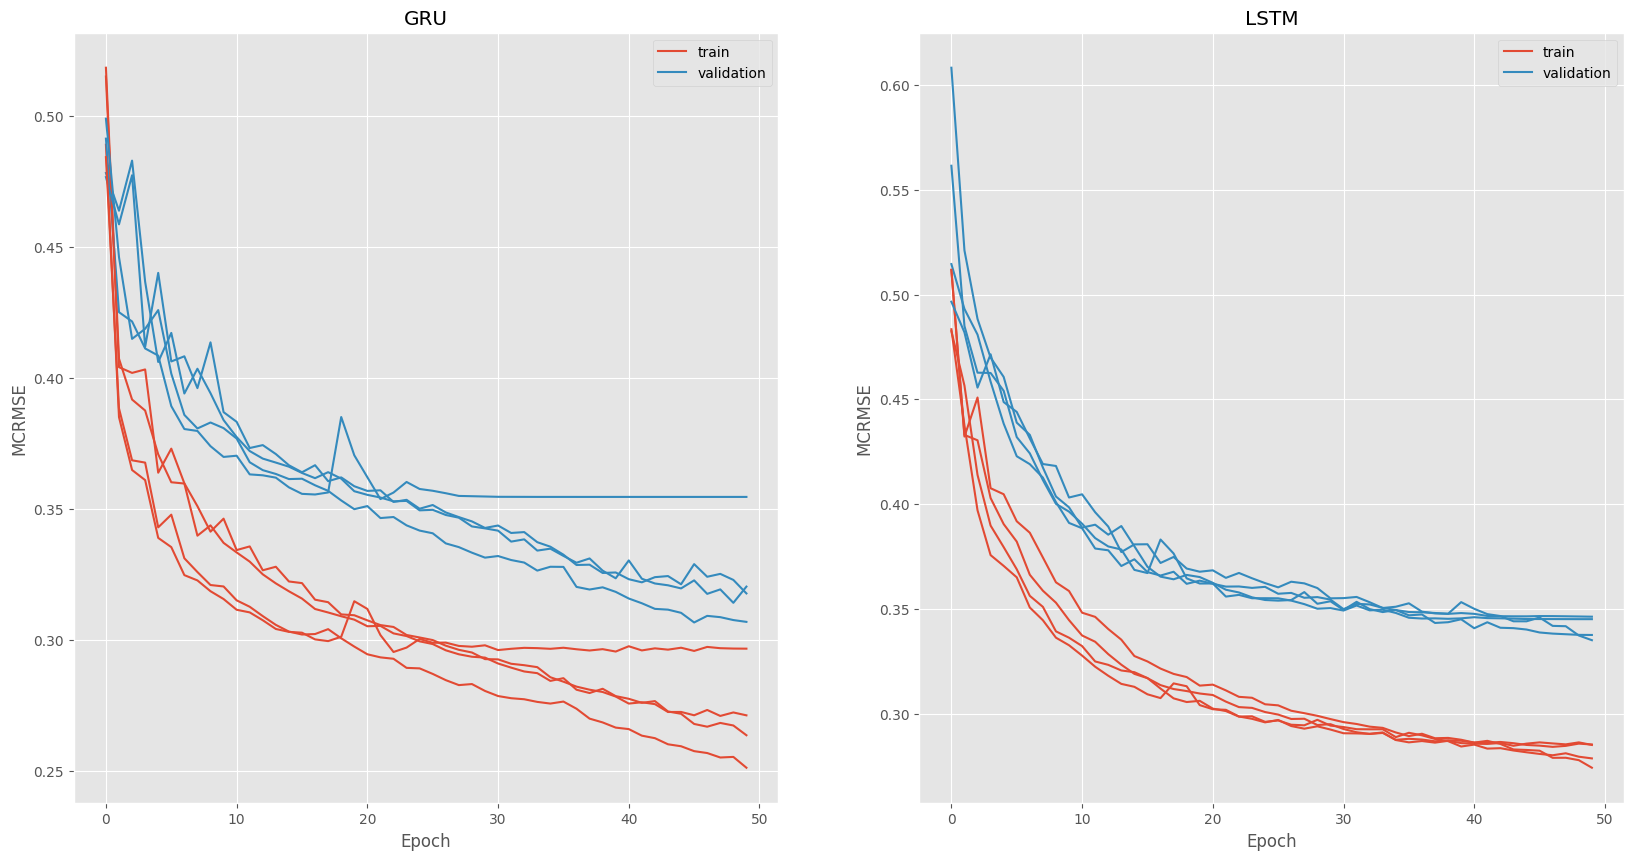

In [ ]:
plot_learning_curves(results)

In [ ]:
gru_val_preds = format_predictions(gru_holdouts, gru_holdout_preds, val=True)
lstm_val_preds = format_predictions(lstm_holdouts, lstm_holdout_preds, val=True)

print('-'*25); print('Unfiltered training results'); print('-'*25)
print('GRU training results'); print('')
get_error(gru_val_preds)
print('LSTM training results'); print('')
get_error(lstm_val_preds)

print('-'*25); print('SN_filter == 1 training results'); print('-'*25)
print('GRU training results'); print('')
get_error(gru_val_preds[gru_val_preds['SN_filter'] == 1])
print('LSTM training results'); print('')
get_error(lstm_val_preds[lstm_val_preds['SN_filter'] == 1])

-------------------------
Unfiltered training results
-------------------------
GRU training results

reactivity 0.7903542717499332 0.6246598748733673
deg_Mg_pH10 0.6513769734372341 0.4242919615242512
deg_Mg_50C 0.9673033154474308 0.9356757040755918
0.8030115202115327 0.6615425134910701

LSTM training results

reactivity 0.7890415709721997 0.6225866007222769
deg_Mg_pH10 0.6623965736886225 0.4387692208344267
deg_Mg_50C 0.9712637708898981 0.9433533126432645
0.8075673051835736 0.668236378066656

-------------------------
SN_filter == 1 training results
-------------------------
GRU training results

reactivity 0.29419852367676197 0.08655277133358628
deg_Mg_pH10 0.406610437807688 0.16533204813415972
deg_Mg_50C 0.3461064999660623 0.11978970931875789
0.3489718204835041 0.12389150959550128

LSTM training results

reactivity 0.3007124231963178 0.09042796146460133
deg_Mg_pH10 0.43310522331240475 0.187580134460488
deg_Mg_50C 0.364982244201775 0.1332120385825641
0.3662666302368325 0.1370733781692

In [ ]:
gru_preds = [gru_public_preds, gru_private_preds]
lstm_preds = [gru_public_preds, gru_private_preds]
test_df = [public_df, private_df]
gru_preds = format_predictions(test_df, gru_preds)
lstm_preds = format_predictions(test_df, lstm_preds)

In [ ]:
gru_weight = 0.5
lstm_weight = 0.5

In [ ]:
blended_preds = pd.DataFrame()
blended_preds['id_seqpos'] = gru_preds['id_seqpos']
blended_preds['reactivity'] = gru_weight*gru_preds['reactivity'] + lstm_weight*lstm_preds['reactivity']
blended_preds['deg_Mg_pH10'] = gru_weight*gru_preds['deg_Mg_pH10'] + lstm_weight*lstm_preds['deg_Mg_pH10']
blended_preds['deg_pH10'] = gru_weight*gru_preds['deg_pH10'] + lstm_weight*lstm_preds['deg_pH10']
blended_preds['deg_Mg_50C'] = gru_weight*gru_preds['deg_Mg_50C'] + lstm_weight*lstm_preds['deg_Mg_50C']
blended_preds['deg_50C'] = gru_weight*gru_preds['deg_50C'] + lstm_weight*lstm_preds['deg_50C']

In [ ]:
submission = sample_sub[['id_seqpos']].merge(blended_preds, on=['id_seqpos'])
submission.head()

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0  id_021cec502_0    0.594017     0.774105  1.965263    0.623012  0.700322
1  id_021cec502_0    0.594017     0.774105  1.965263    0.623012  0.700322
2  id_021cec502_0    0.594017     0.774105  1.965263    0.623012  0.700322
3  id_021cec502_0    0.594017     0.774105  1.965263    0.623012  0.700322
4  id_021cec502_1    1.348265     1.788551  2.578889    1.814597  1.606963

In [ ]:
submission.to_csv(f'submission_new.csv', index=False)
print('Submission saved')

Submission saved


In [ ]:
!pip install flask-ngrok

In [ ]:
import os
os.mkdir("templates")
os.mkdir("static")

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def welcome():
  return render_template('welcome.html')

@app.route("/welcome.html")
def home():
  return render_template('welcome.html')

@app.route("/KnowMore.html")
def KnowMore():
  return render_template('KnowMore.html')

@app.route("/Models.html")
def Models():
  return render_template('Models.html')

@app.route("/Play.html")
def Play():
  return render_template('Play.html')

if __name__ == '__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://bbf78c20e161.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/May/2021 14:18:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:18:58] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:18:58] "GET /static/corona.jpg HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:18:58] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [03/May/2021 14:19:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:01] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:02] "GET /static/corona.jpg HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:05] "GET /KnowMore.html HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:16] "GET /Models.html HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:26] "GET /KnowMore.html HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:44] "GET /Play.html HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:19:59] "GET /KnowMore.html HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:20:04] "GET /Play.html HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 14:20:06] "GET /Models.html HTTP/1.1" 200 -
127.